Please go to https://drive.google.com/file/d/1V39M1GIchPfiV23lacJ3H54pPl5qYAQY/view?usp=sharing to view my full table and graph outputs.

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
import geopandas as gpd
from shapely.geometry import Point
import plotly.express as px
import plotly.graph_objects as go
import requests
from bs4 import BeautifulSoup
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
from IPython.display import display, HTML
from statsmodels.stats.outliers_influence import variance_inflation_factor
import qeds
from sklearn import tree
import patsy
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
import itertools
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from statsmodels.discrete.discrete_model import Logit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
from math import ceil
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
df = pd.read_csv(r'/Users/gongzichen/Desktop/coding/ECO225/dataset/fatal_encounters_dot_org.csv')
# Replacing space by "_" in column titles
df.columns = [c.replace(' ', '_') for c in df.columns]

# Project 1

## Introduction

Police forces are established to maintain law and order while safeguarding people's lives and property. However, there have been instances where deaths have occurred in the presence of police officers, which were not directly the result of intentional police actions but rather due to police or officer presence at the scene [2]. Such violence involving police presence has increasingly attracted public attention in recent years, both within and beyond the United States. For instance, Canada's Winnipeg police recently disclosed details of male suicide in police presence [4].

Fatal Encounters, a team of researchers from the University of Southern California, has been tracking these atypical deaths during interactions with police since January 1, 2001, using social media and police reports as sources [2]. While media reports may only sometimes be accurate and information provided by the police can be incomplete, this team has diligently compiled this dataset, transforming it into a searchable national resource. However, the dataset's completeness varies across years, with data from some years needing to be completed more. Consequently, this inconsistency may impede time series analysis, necessitating statistical inferences based on cumulative case results without considering time.

Various factors, including officer pursuits, suicides, and homicides, contribute to these deadly incidents. In this study, we will examine the likelihood of one specific type of deadly force that resulted in these fatalities: gunshots. We aim to determine whether some or all of the indicators, including the subject's gender, race, and the state of the incident, may relate to gunshot-related deaths. Preliminary data summaries and visualizations reveal significant variations in gunshot case counts across U.S. states, genders, and races.

A higher number of police-involved deaths were observed in some West coast states. However, when adjusted for state population, the proportion of gunshot-related deaths significantly diverges from the results based on raw death case counts. States in the central U.S. exhibit the highest proportion of deaths per population after adjusting for state population. Furthermore, states with higher average per-capita income tend to have a lower proportion of gunshot-related deaths, but the trend is not visible enough. Male victims overwhelmingly outnumber female victims, and white victims constitute a significant proportion. Nevertheless, this observation becomes less clear when compared to the population distribution of each race in the United States. After adjusting for race and ethnicity, the African-American/Black population is more likely to experience gunshot-related deaths in incidents involving police violence. 

The findings above indicate the necessity of employing mathematical and statistical tools to verify the associations between gunshot-related fatalities and factors such as gender, race, and region rather than relying solely on empirical images and tables. In this study, we have established two basic regression models. The first model is a logistic regression model, which takes the binary variable of whether a victim dies from a gunshot in the presence of the police as the dependent variable and uses the victim's gender and race as two factor variables for independent variables. The second model is a linear regression model that replaces the individual level with the state level, using the total number of victims who died from gunshots/non-gunshots in a U.S. state as the dependent variable and incorporating the state's racial distribution data, gender distribution data, and per-capita income data as independent variables. Additionally, we briefly transformed both models into regression trees for some basic machine learning prediction. The study results indicate that a certain degree of gender and racial inequality exists in such violent incidents, while regional differences are not as pronounced and do not align with the findings depicted in the maps. This discrepancy may arise from the varying gender and population compositions of different states, contributing to the differences in regional distribution displayed on the maps. Income disparities do not exhibit high significance in either model.

As Kevin Lang and Ariella Kahn-Lang Spitzer [5] mentioned, the issue of inequality is fundamentally an economic problem. Focusing on areas prone to producing real or perceived inequalities can help guide the development of anti-discrimination policies. They suggest that discrimination may manifest as "taste-based" and "statistical." The former reflects personal biases or preferences, while the latter is based on empiricism. In the context of this study, it is possible that, in the presence of law enforcement, some government officials or police officers may allow personal biases to contribute to tragic outcomes, representing the first form of discrimination. Alternatively, heightened vigilance by police officers in response to specific demographics with historically higher crime rates could also play a role, illustrating the second form of discrimination.

## Data Cleaning

In [3]:
# Convert str characters into lower cases in column A_brief_description_of_the_circumstances_surrounding_the_death
df['A_brief_description_of_the_circumstances_surrounding_the_death'] = df[
    'A_brief_description_of_the_circumstances_surrounding_the_death'].str.lower()

In [4]:
# create a list of stop words
stop_words = set(stopwords.words("english"))
new_words =  ['out', 'police.', 'killed.', 'shot', 'officer', 'officers', 'allegedly', 'said', 'said.', 'two', 'one', 
              'according', 'him.', 'deputies', 'deputy', 'died', 'reportedly', 'found', 'responded', 'tried', 'stop', 
              'called', 'county', 'around', 'call', 'attempted', 'three', 'pointed', 'inside', 'police,', 'fleeing', 
              'went', 'several', 'saw', 'report', 'domestic', 'another', 'began', 'got', 'police', 'told', 
              "sheriff's", 'reported', 'dead', 'killed', 'back', 'arrived', 'drop', 'state', 'near', 'responding', 
              'approached', 'stopped', 'trooper', 'fatally', 'patrol', 'chased', 'house', 'later', 'gun.', 'family', 
              'came', 'arrived,']
stop_words = stop_words.union(new_words)

In [5]:
# Keep only columns that I will be using in the future and drop Nah values
# Rename columns
df = df.drop({"Unique_ID", "Subject's_name", "Subject's_race", "Imputation_probability", "URL_of_image_of_deceased", 
              "Date_of_injury_resulting_in_death_(month/day/year)", "Location_of_injury_(address)", 
              "Location_of_death_(city)", "Location_of_death_(zip_code)", "Location_of_death_(county)", 
              "Full_Address", "Agency_responsible_for_death", 
              "Dispositions/Exclusions_INTERNAL_USE,_NOT_FOR_ANALYSIS", "Intentional_Use_of_Force_(Developing)",
              "Link_to_news_article_or_photo_of_official_document", "Video", "Date&Description",
              "Symptoms_of_mental_illness?_INTERNAL_USE,_NOT_FOR_ANALYSIS", "Unique_ID_formula", 
              "Unique_identifier_(redundant)"}, axis = 1)
df = df.rename(columns={"Subject's_age": "Age", "Subject's_gender": "Gender", "Date_(Year)": "Year",
                        "Subject's_race_with_imputations": "Race", "Location_of_death_(state)": "State", 
                        "A_brief_description_of_the_circumstances_surrounding_the_death": "Circumstances"}).dropna()

In [6]:
# Convert Cause_of_death into a binary variable indicating whether the cause was Gunshot or not
df["Cause_of_death"] = np.where(df["Cause_of_death"] == "Gunshot", 1, 0)

## Summary Statistics Tables

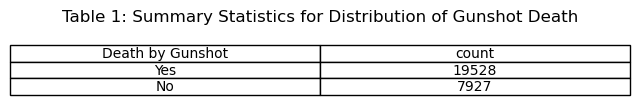

In [7]:
# Summary statistics for Y variable
Gunshot_sum = pd.DataFrame(df["Cause_of_death"].value_counts()).reset_index().rename(
    columns = {"index": "Death by Gunshot", "Cause_of_death": "count"})

Gunshot_sum.at[0, "Death by Gunshot"] = "Yes"
Gunshot_sum.at[1, "Death by Gunshot"] = "No"

fig = plt.figure(figsize = (8, .2))
ax = fig.add_subplot(111)

ax.table(cellText = Gunshot_sum.values, colLabels = Gunshot_sum.columns, cellLoc = 'center')
ax.set_title("Table 1: Summary Statistics for Distribution of Gunshot Death")
ax.axis('off')

plt.show()

The response variable of our model is a binary one, indicating whether one victim died from a gunshot. In Table 1, gunshots cause the most deaths, and the number of gunshot deaths is more than twice as many as the number of other deaths. 

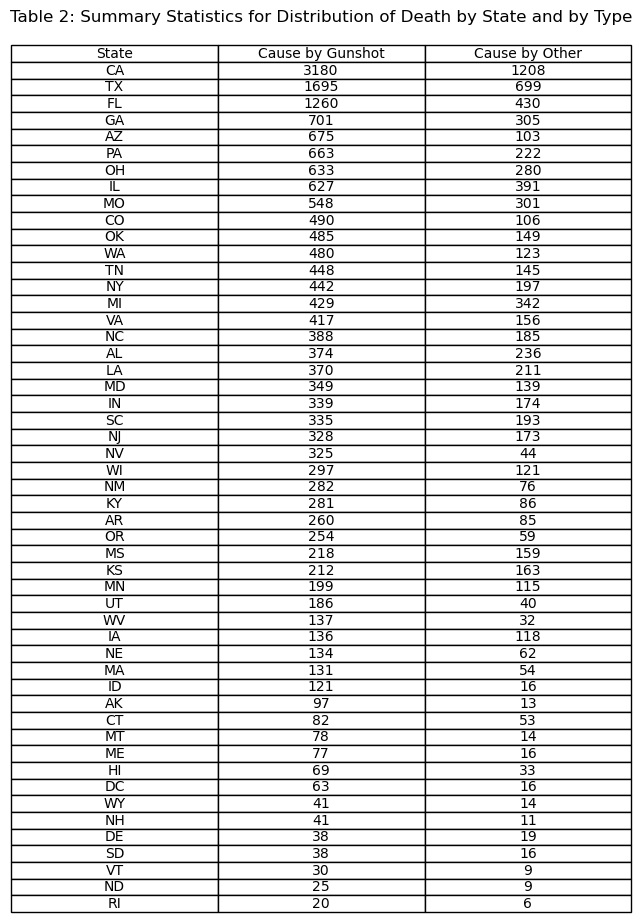

In [8]:
# Summary statistics for Death by State
death_by_state = pd.DataFrame(df.groupby("State")["Cause_of_death"].value_counts()).rename(
    columns = {"Cause_of_death": "Count"})
death_by_state = death_by_state.reset_index().sort_values(["Count"], ascending = False)

Gunshot_cause = death_by_state[death_by_state["Cause_of_death"] == 1]
Other_cause = death_by_state[death_by_state["Cause_of_death"] == 0]

death_by_state = pd.merge(Gunshot_cause, Other_cause, on = 'State')
death_by_state = death_by_state.rename(columns = {"Count_x": "Cause by Gunshot", "Count_y": "Cause by Other"}).drop(
    {"Cause_of_death_x", "Cause_of_death_y"}, axis = 1)

fig = plt.figure(figsize = (8, .2))
ax = fig.add_subplot(111)

ax.table(cellText = death_by_state.values, colLabels = death_by_state.columns, cellLoc = 'center')
ax.set_title("Table 2: Summary Statistics for Distribution of Death by State and by Type")
ax.axis('off')

plt.show()

Table 2 demonstrates the number of deaths per state, and the death counts are categorized into two groups: caused by gunshots and caused by other factors. The table sequence is sorted in a descending trend based on the number of deaths caused by gunshots. We see that the state of California has a predominantly large number of gunshot-caused deaths and all deaths, which might have caused the large population in California. However, if we compare the number of counts in California with other states with a high population, like New York, we see that California still dominates the game. We cannot conclude the critical factor that leads to this situation, whether this is because police officers from California are not well-trained until we have further information from the initiator of this dataset. 

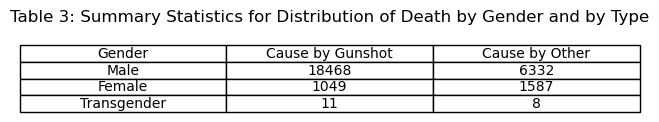

In [9]:
# Summary statistics for Death Distribution by Gender and by Type
death_by_gender = pd.DataFrame(df.groupby("Gender")["Cause_of_death"].value_counts()).rename(
    columns = {"Cause_of_death": "Count"})
death_by_gender = death_by_gender.reset_index().sort_values(["Count"], ascending = False)

Gunshot_cause = death_by_gender[death_by_gender["Cause_of_death"] == 1]
Other_cause = death_by_gender[death_by_gender["Cause_of_death"] == 0]

death_by_gender = pd.merge(Gunshot_cause, Other_cause, on = 'Gender')
death_by_gender = death_by_gender.rename(columns = {"Count_x": "Cause by Gunshot", "Count_y": "Cause by Other"}).drop(
    {"Cause_of_death_x", "Cause_of_death_y"}, axis = 1)

fig = plt.figure(figsize = (8, .2))
ax = fig.add_subplot(111)

ax.table(cellText = death_by_gender.values, colLabels = death_by_gender.columns, cellLoc = 'center')
ax.set_title("Table 3: Summary Statistics for Distribution of Death by Gender and by Type")
ax.axis('off')

plt.show()

According to Table 3, no matter whether it is caused by gunshot or other factors, the death count is highest for males than for females and the transgender population. Besides the fact that the transgender population is a smaller group compared with the male and female groups, this table might indicate that the male population is more likely to become victims in encounters with the police. However, we should remember that the death statistics also include officer deaths. In the year 2021, as published by Statista showed that among U.S. law enforcement officers, the gender ratio is highly skewed, with a predominantly high proportion of 72.2% as male employees [3]. As a result, a certain proportion of male deaths might come from officers as well, which makes the count of male deaths much more than the number of female deaths. 

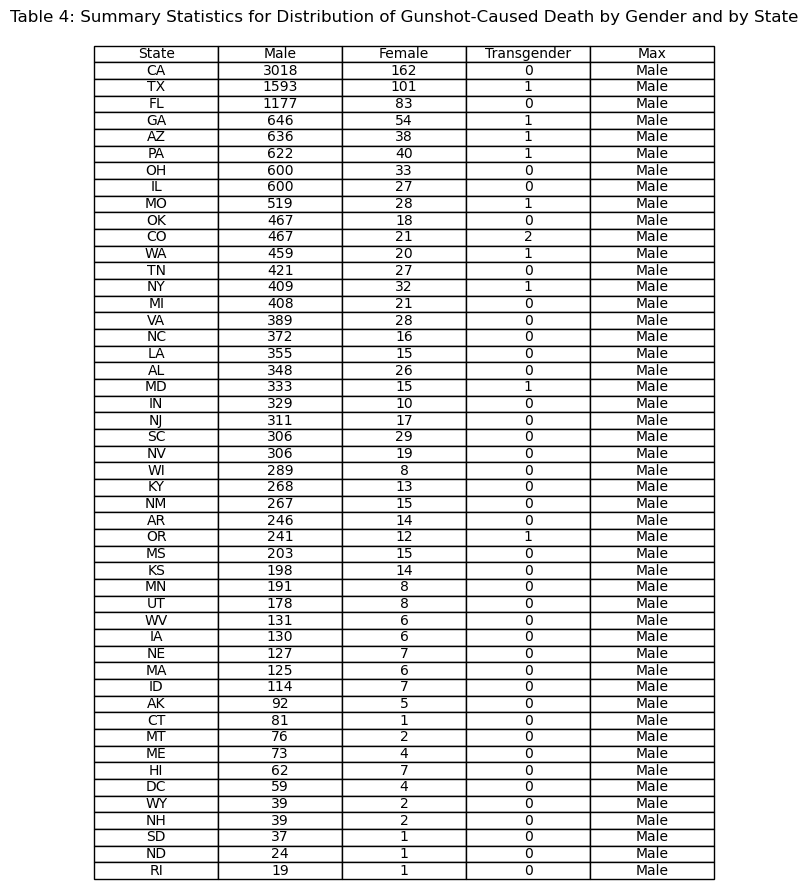

In [10]:
# Death Caused by Gunshot and Distribution by Gender and by State
gunshot_death = df[df['Cause_of_death'] == 1]

gender_by_state = pd.DataFrame(gunshot_death.groupby("State")["Gender"].value_counts()).rename(
    columns = {"Gender": "Count"})
gender_by_state = gender_by_state.reset_index().sort_values(["Count"], ascending = False)

male_by_state = gender_by_state[gender_by_state['Gender'] == "Male"]
female_by_state = gender_by_state[gender_by_state['Gender'] == "Female"]
trans_by_state = gender_by_state[gender_by_state['Gender'] == "Transgender"]

gender_by_state = pd.merge(male_by_state, female_by_state, on = 'State')
gender_by_state = pd.merge(gender_by_state, trans_by_state, on = "State", how = "outer").rename(
    columns = {"Count": "Transgender", "Count_x": "Male", "Count_y": "Female"}).drop(
    {"Gender_x", "Gender_y", "Gender"}, axis = 1).fillna(0)
gender_by_state["Transgender"] = pd.to_numeric(gender_by_state["Transgender"], downcast = 'integer')
genderMax_test = gender_by_state.drop({"State"}, axis = 1)
maxValueIndex = genderMax_test.idxmax(axis=1)
gender_by_state["Max"] = maxValueIndex

fig = plt.figure(figsize = (8, .2))
ax = fig.add_subplot(111)

ax.table(cellText = gender_by_state.values, colLabels = gender_by_state.columns, cellLoc = 'center')
ax.set_title("Table 4: Summary Statistics for Distribution of Gunshot-Caused Death by Gender and by State")
ax.axis('off')

plt.show()

In Table 4, we intend to see the interaction between gender and states for a gunshot death. The result shows that no matter the state where the incident occurred, most incidents happened to males. Except for the transgender population, which has a smaller proportion in the whole population, we expect that the proportion of the female and male population should be approximately the same among the U.S. population. Under this assumption, we see that the gender of victims is uncorrelated with their location of incidence. 

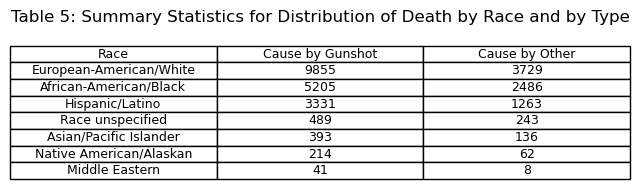

In [11]:
# Summary statistics for Death Distribution by Race and by Type
death_by_race = pd.DataFrame(df.groupby("Race")["Cause_of_death"].value_counts()).rename(
    columns = {"Cause_of_death": "Count"})
death_by_race = death_by_race.reset_index().sort_values(["Count"], ascending = False)

Gunshot_cause = death_by_race[death_by_race["Cause_of_death"] == 1]
Other_cause = death_by_race[death_by_race["Cause_of_death"] == 0]

death_by_race = pd.merge(Gunshot_cause, Other_cause, on = 'Race')
death_by_race = death_by_race.rename(columns = {"Count_x": "Cause by Gunshot", "Count_y": "Cause by Other"}).drop(
    {"Cause_of_death_x", "Cause_of_death_y"}, axis = 1)

fig = plt.figure(figsize = (8, .2))
ax = fig.add_subplot(111)

ax.table(cellText = death_by_race.values, colLabels = death_by_race.columns, cellLoc = 'center')
ax.set_title("Table 5: Summary Statistics for Distribution of Death by Race and by Type")
ax.axis('off')

plt.show()

Table 5, similar to Tables 2 and 3, lists the death count for different races, and these counts are categorized into two groups indicating a gunshot death or other deaths. Many white people who died compared to other races seem to come from the primarily white population proportion in the U.S. However, compared with the proportion of the white population in 2021 U.S. census data, the white population takes up to approximately 75.8% percent, which is five times more than the black population [8]. While in Table 4, the number of white deaths is not even twice as many as black deaths. If we consider the white and black populations, the proportion of white people who died is much smaller than that of black people. 

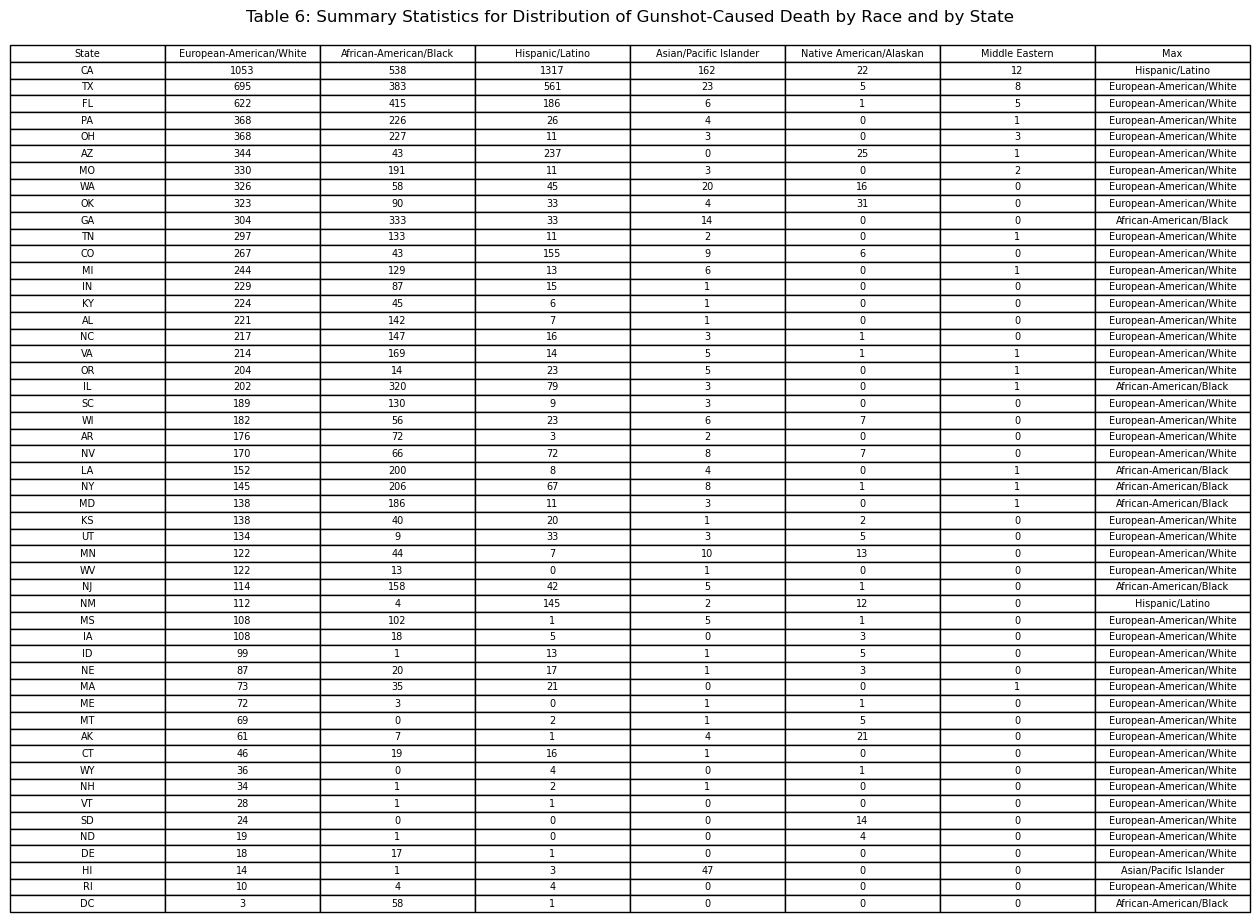

In [12]:
# Death Caused by Gunshot and Distribution by Race and by State
race_by_state = pd.DataFrame(gunshot_death.groupby("State")["Race"].value_counts()).rename(
    columns = {"Race": "Count"})
race_by_state = race_by_state.reset_index().sort_values(["Count"], ascending = False)

white_by_state = race_by_state[race_by_state['Race'] == "European-American/White"]
black_by_state = race_by_state[race_by_state['Race'] == "African-American/Black"]
latino_by_state = race_by_state[race_by_state['Race'] == "Hispanic/Latino"]
asian_by_state = race_by_state[race_by_state['Race'] == "Asian/Pacific Islander"]
native_by_state = race_by_state[race_by_state['Race'] == "Native American/Alaskan"]
middleE_by_state = race_by_state[race_by_state['Race'] == "Middle Eastern"]

race_by_state = pd.merge(white_by_state, black_by_state, on = 'State', how = "outer")
race_by_state = pd.merge(race_by_state, latino_by_state, on = 'State', how = "outer").rename(
    columns = {"Count_x": "European-American/White", "Count_y": "African-American/Black", 
               "Count": "Hispanic/Latino"}).drop({"Race_x", "Race_y", "Race"}, axis = 1)
race_by_state = pd.merge(race_by_state, asian_by_state, on = 'State', how = "outer")
race_by_state = pd.merge(race_by_state, native_by_state, on = 'State', how = "outer")
race_by_state = pd.merge(race_by_state, middleE_by_state, on = "State", how = "outer").rename(
    columns = {"Count_x": "Asian/Pacific Islander", "Count_y": "Native American/Alaskan", 
               "Count": "Middle Eastern"}).drop({"Race_x", "Race_y", "Race"}, axis = 1).fillna(0)

race_by_state["African-American/Black"] = pd.to_numeric(
    race_by_state["African-American/Black"], downcast = 'integer')
race_by_state["Hispanic/Latino"] = pd.to_numeric(
    race_by_state["Hispanic/Latino"], downcast = 'integer')
race_by_state["Asian/Pacific Islander"] = pd.to_numeric(
    race_by_state["Asian/Pacific Islander"], downcast = 'integer')
race_by_state["Native American/Alaskan"] = pd.to_numeric(
    race_by_state["Native American/Alaskan"], downcast = 'integer')
race_by_state["Middle Eastern"] = pd.to_numeric(
    race_by_state["Middle Eastern"], downcast = 'integer')
raceMax_test = race_by_state.drop({"State"}, axis = 1)
maxValueIndex = raceMax_test.idxmax(axis=1)
race_by_state["Max"] = maxValueIndex

fig = plt.figure(figsize = (16, 0.2))
ax = fig.add_subplot(111)

ax.table(cellText = race_by_state.values, colLabels = race_by_state.columns, cellLoc = 'center')
ax.set_title("Table 6: Summary Statistics for Distribution of Gunshot-Caused Death by Race and by State")
ax.axis('off')

plt.show()

Table 6 is designed to demonstrate if there is any potential correlation between the race of victims and the state where the incident happened. From the table, we see that in most states, the largest number of gunshot-incurred death took place in the white population, which should not be a huge surprise when we have already noticed that the white population has a dominating proportion in the U.S. [8]. There are several cases where the largest number of victims were from other races like black and Latino, the state feature might cause this. For example, certain states might have a larger black population. In this case, we can say that the victims' race and the location of the incident are uncorrelated.

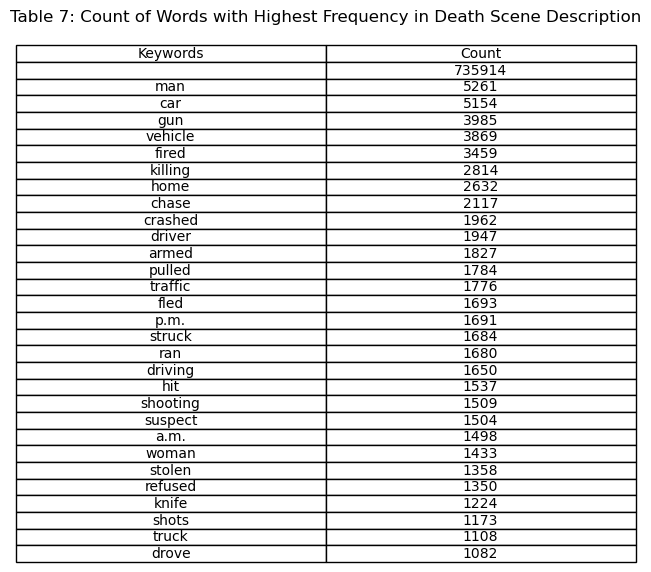

In [13]:
# Count the frequency of top used words in death description
words_freq = df.Circumstances.str.split(expand = True).stack().apply(lambda x: ' '.join(
    [item for item in x.split() if item not in stop_words])).value_counts()
words_freq = pd.DataFrame(words_freq.head(30)).reset_index().rename(columns = {"index": "Keywords", 0: "Count"})

fig = plt.figure(figsize = (8, .2))
ax = fig.add_subplot(111)

ax.table(cellText = words_freq.values, colLabels = words_freq.columns, cellLoc = 'center')
ax.set_title("Table 7: Count of Words with Highest Frequency in Death Scene Description")
ax.axis('off')

plt.show()

In addition to quantitative analysis, I also want to show some superficial qualitative analysis. In Table 5, after removing some meaningless words like "a," "that," and "several," we found that the frequency of "men" in scene descriptions is much higher than that of "women." In the time description, "p.m." appears more frequently than "a.m." At the same time, some words that reveal violent methods, such as "gun," "vehicle", "car", and "shooting", or some intense or relatively harmful verbs, such as "chase", "crashed," and "fled" also appears frequently, as if showing us that the scene where death appears is not peaceful.

## Plots and Figures

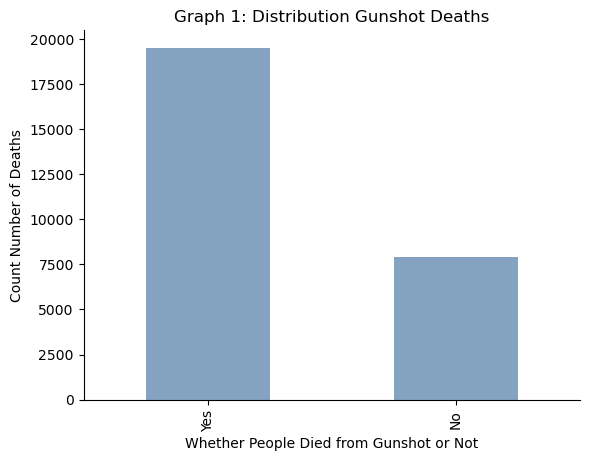

In [14]:
# Distribution of Y variable, the binary Gunshot Death Cause
fig, ax = plt.subplots()

Gunshot_sum["count"].plot(kind = "bar", ax = ax, color = (0.2, 0.4, 0.6, 0.6))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('Whether People Died from Gunshot or Not')
ax.set_ylabel('Count Number of Deaths')
ax.set_title('Graph 1: Distribution Gunshot Deaths')
ax.set_xticklabels(('Yes', 'No'))

plt.show()

Graph 1 is like a visualization of Table 1. Similar to what we read from Table 1, the number of people who died from a gunshot is more than twice as many as people who died from other reasons. This binary variable is our response variable. 

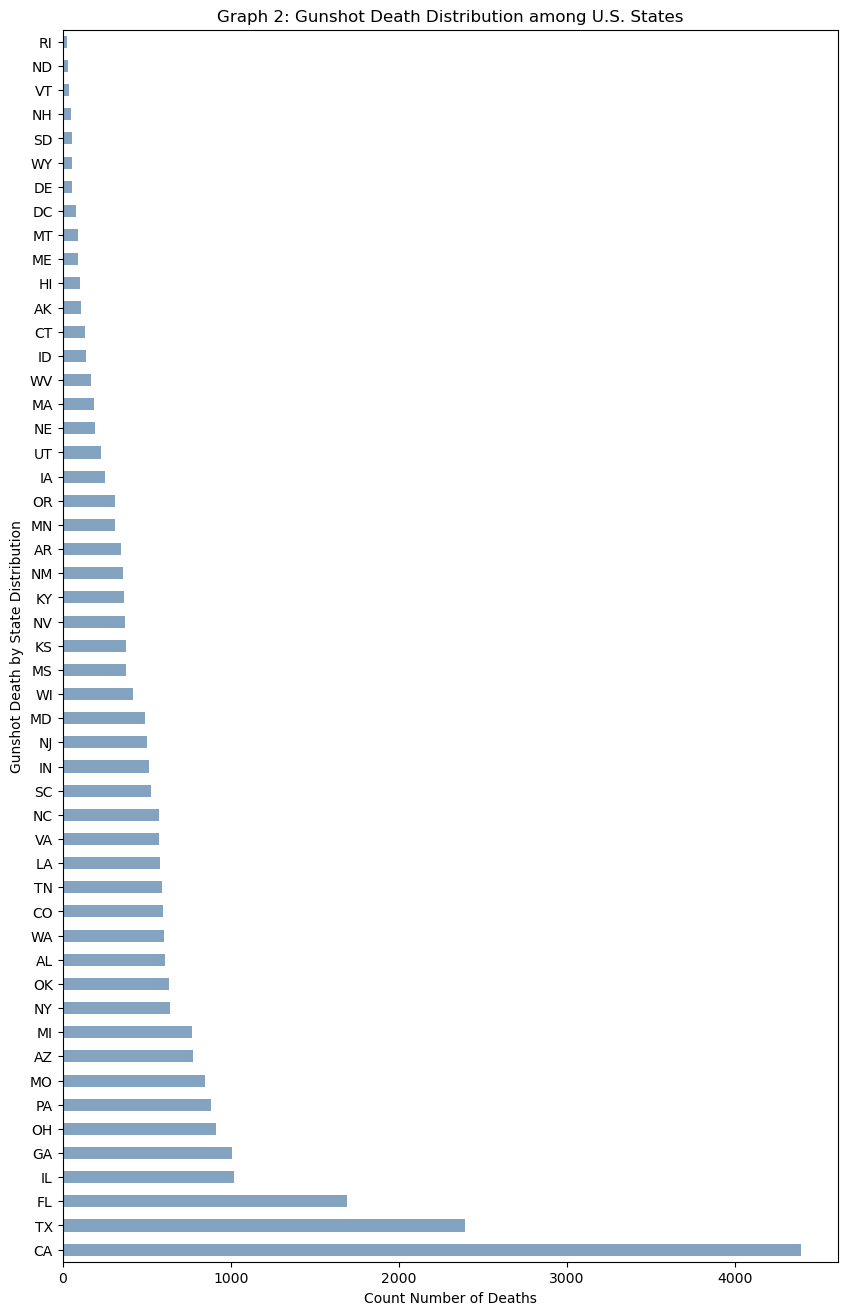

In [15]:
# Number of Death Distribution by State 
fig, ax = plt.subplots(figsize = (10, 16))

df['State'].value_counts().plot(kind='barh', color = (0.2, 0.4, 0.6, 0.6))

ax.set_ylabel('Gunshot Death by State Distribution')
ax.set_xlabel('Count Number of Deaths')
ax.set_title('Graph 2: Gunshot Death Distribution among U.S. States')

plt.show()

Unlike Table 2, which categorizes death counts into gunshot factors and other factors and sorts the sequence only based on the number of deaths from a gunshot, this Graph 2 shows an overview of all deaths in total. California, Texas, and Florida, these three states dominate in the number of deaths with police at the scene.

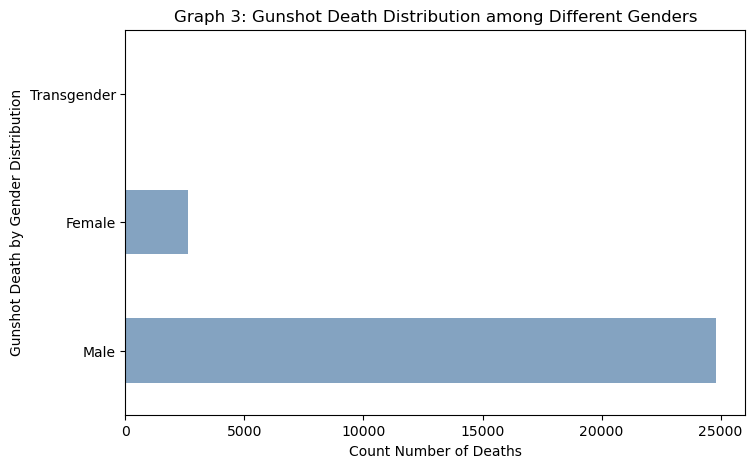

In [16]:
# Number of Death Distribution by Gender 
fig, ax = plt.subplots(figsize = (8, 5))

df['Gender'].value_counts().plot(kind='barh', color = (0.2, 0.4, 0.6, 0.6))

ax.set_ylabel('Gunshot Death by Gender Distribution')
ax.set_xlabel('Count Number of Deaths')
ax.set_title('Graph 3: Gunshot Death Distribution among Different Genders')

plt.show()

If we do not categorize deaths by reason but only display the total number of deaths, the male deaths are more than five times as many as female deaths. Deaths from the transgender group are almost not visible in Graph 3. However, as indicated before, this can only somehow show that gender is associated with the number of deaths, but we should not infer any causal relationship from this plot. 

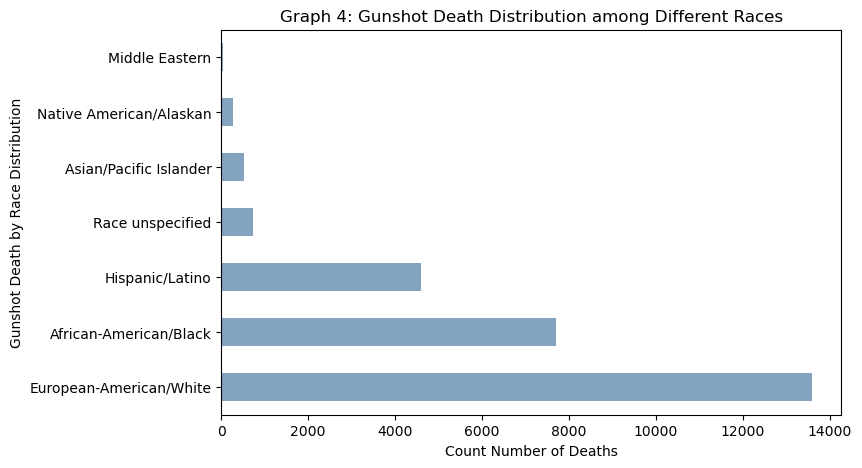

In [17]:
# Number of Death Distribution by Race
fig, ax = plt.subplots(figsize = (8, 5))

df['Race'].value_counts().plot(kind='barh', color = (0.2, 0.4, 0.6, 0.6))

ax.set_ylabel('Gunshot Death by Race Distribution')
ax.set_xlabel('Count Number of Deaths')
ax.set_title('Graph 4: Gunshot Death Distribution among Different Races')

plt.show()

Compared with races like Middle Eastern, Asian/Pacific Islander, and Hispanic/Latino, which take only a tiny proportion of the U.S. population, the European-American/White population dominated in the U.S. [8]. However, as another minority group, African-American/Black, the number of deaths from this group is more than half that of the white population group. We are not sure if the defining feature, race, would have any causal relationship with the number of deaths. 

# Project 2

## The Message

In project 1, I have created graphs illustrating the relationship between my response variable, the gunshot-incurred deaths, and my independent variables, the victim's gender, race, and location in the U.S. In these graphs, I try to visualize whether one victim's chance of dying from a gunshot is related to the victim's gender, race, or location in the U.S. I could not make any causal inference from these graphs. However, they would support my further analysis using more rigorous mathematical and statistical models. For convenience reasons, I moved these subgroup plots into project 2.

For the graph plotting my response variable divided by states as subgroups, first, I include only gunshot deaths in the first barplot with gunshot counts distributed among states in project 1. I have U.S. states as the x-axis and the count of gunshot deaths as the y-axis. I did not include other deaths to avoid chaos in the graph caused by too much information. We should be aware that there are many states in the U.S. 

Later I included a boxplot with whether a victim died from a gunshot as the x-axis and the count of deaths in different states as the y-axis. This plot is used to demonstrate further my dependent variable in subgroups, both among states and by the binary category in the x-axis. 

The gender and race variables are both my categorical independent variables. I illustrate the distribution of gunshots and other types of deaths in numerical counts as outcomes in subgroups of genders and races in two plots separately. For the gender plot, I will use three gender groups as subgroups of my dependent variable on the x-axis and the count of deaths caused by gunshot and other as my y-axis. This works similarly for my race plot.

In this project, I want to investigate whether there is any causal relationship between victims' race and their probability of getting a gunshot-incurred death during a fatal encounter, and a causal relationship between victims' gender and probability, and the state where the incident occurred and probability. 

Before I create any model analysis, I want to add one new graph about my response variable to test whether I should conduct the data divided in time series or resort to a cumulative result. This will be visualized using a graph with time in years on the x-axis and a count of death cases on the y-axis.

I then want to use several graphs to demonstrate the relationship between the chance of getting a gunshot-incurred death and the victims' gender, race, and state/location. In addition, I want to show no correlation between gender, race, and location so that these factors do not collectively associate with my response variable. This is beneficial if I want to have any causal inference at the end of my final project. 

At the end of my project, I want to include causal inference statistic tools like regression models.

## Maps, the Time Series Graph, and Interpretations

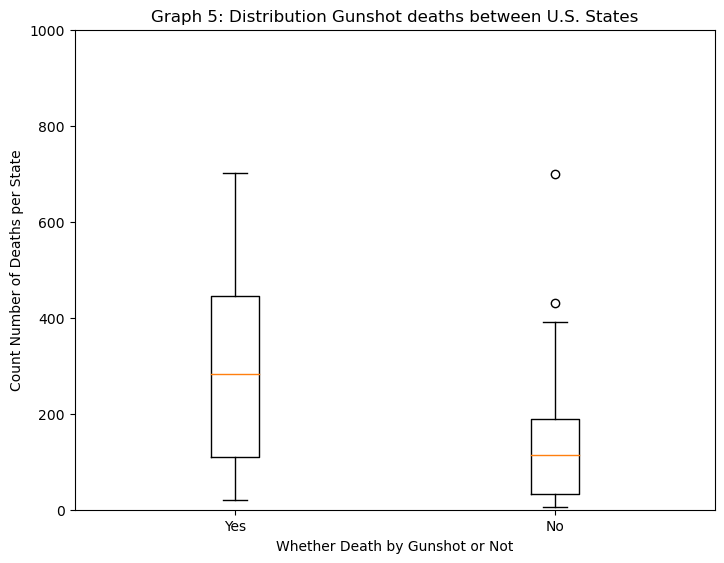

In [18]:
# Plot for distribution of deaths between states
fig = plt.figure() 
ax = fig.add_axes([0, 0, 1, 1])

plt.boxplot(death_by_state[["Cause by Gunshot", "Cause by Other"]])

ax.set_xticklabels(["Yes", "No"])
ax.set_title("Graph 5: Distribution Gunshot deaths between U.S. States")
ax.set_xlabel('Whether Death by Gunshot or Not')
ax.set_ylabel('Count Number of Deaths per State')

plt.ylim(0, 1000)

plt.show()

Now we investigate the relationship between three indicator variables and the response variable. In Graph 5, we see that except for several outliers from the "Death not caused by gunshot" group, the middle 50 percent of the number of deaths caused by gunshot are mostly greater than deaths not caused by gunshot for each state. Remember that in the group, death is not caused by gunshot, it is a composition of several different death causes, but the sum of them still cannot compare to that of the number of deaths by gunshot. The variation of death counts between states shows that there might be association or even causal relationship between states and types of deaths.

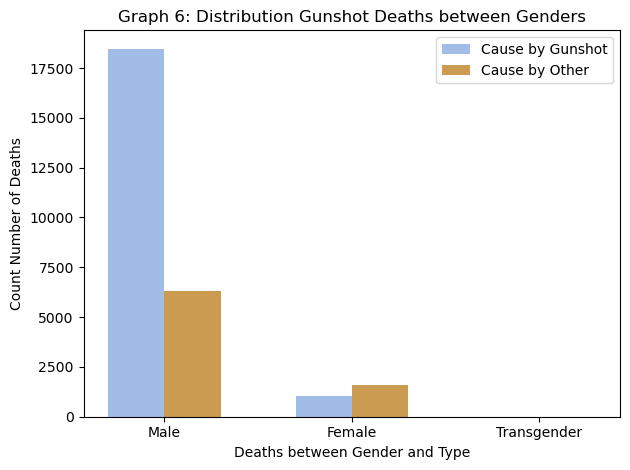

In [19]:
# Plot for distribution of deaths between gender
n_groups = 3

Gunshot = death_by_gender["Cause by Gunshot"]
Other = death_by_gender["Cause by Other"]

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.3

color_Gunshot = mplc.hsv_to_rgb((0.6, 0.3, 0.9))
rects1 = ax.bar(index, Gunshot, bar_width, color = color_Gunshot, label = 'Cause by Gunshot')

color_Other = mplc.hsv_to_rgb((0.1, 0.6, 0.8))
rects2 = ax.bar(index + bar_width, Other, bar_width, color = color_Other, label = 'Cause by Other'
)

ax.set_xlabel('Deaths between Gender and Type')
ax.set_ylabel('Count Number of Deaths')
ax.set_title('Graph 6: Distribution Gunshot Deaths between Genders')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('Male', 'Female', 'Transgender'))
ax.legend()

fig.tight_layout()

From the previous graph, we know that the number of deaths caused by gunshots is much more than the number of deaths caused by other factors. In Graph 6, we see that for females, the number of deaths caused by other factors is slightly more than those caused by gunshots. At the same time, the overall trend fits that from Table 3, where the number of male deaths is much more than the other two categories. The variation of death counts between genders shows that there might be association or even causal relationship between gender of victims and types of deaths.

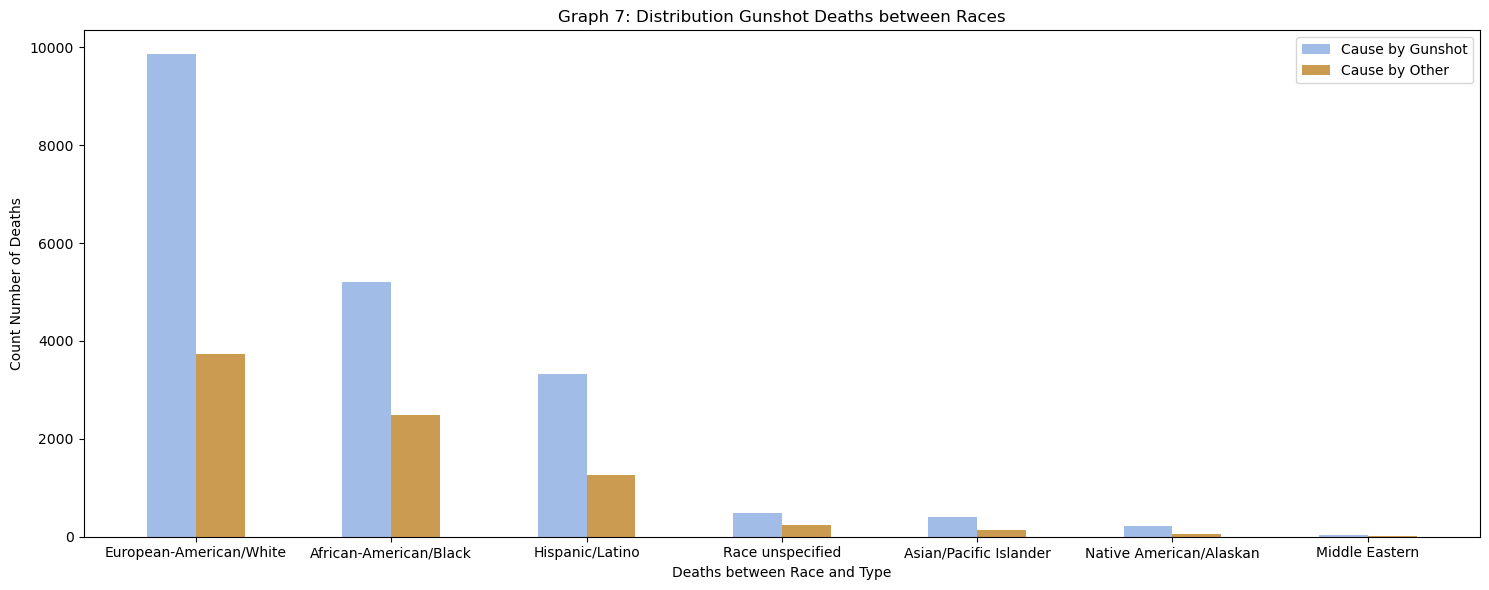

In [20]:
# Plot for the distribution of deaths between races
n_groups = 7

Gunshot = death_by_race["Cause by Gunshot"]
Other = death_by_race["Cause by Other"]
Race = death_by_race["Race"]


fig, ax = plt.subplots(figsize=(15, 6))

index = np.arange(n_groups)
bar_width = 0.25

color_Gunshot = mplc.hsv_to_rgb((0.6, 0.3, 0.9))
rects1 = ax.bar(index, Gunshot, bar_width, color = color_Gunshot, label = 'Cause by Gunshot')

color_Other = mplc.hsv_to_rgb((0.1, 0.6, 0.8))
rects2 = ax.bar(index + bar_width, Other, bar_width, color = color_Other, label = 'Cause by Other'
)

ax.set_xlabel('Deaths between Race and Type')
ax.set_ylabel('Count Number of Deaths')
ax.set_title('Graph 7: Distribution Gunshot Deaths between Races')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(Race)
ax.legend()

fig.tight_layout()

According to the 2021 U.S. census, the proportion of the Hispanic population is approximately 5 percent more than the proportion of the African-American population, and the white population dominates at around 75.8 percent [8]. In this sense, if we look at Graph 7, the number of deaths that happened to African-Americans is almost half that of European-Americans. In addition, the number of African-American deaths also exceeds the number of Hispanic deaths, even though the Hispanic population is, in fact, more significant than the African-American population. The variation of unproportionate distributed death counts between races shows that there might be an association or even causal relationship between victims' races and types of deaths.

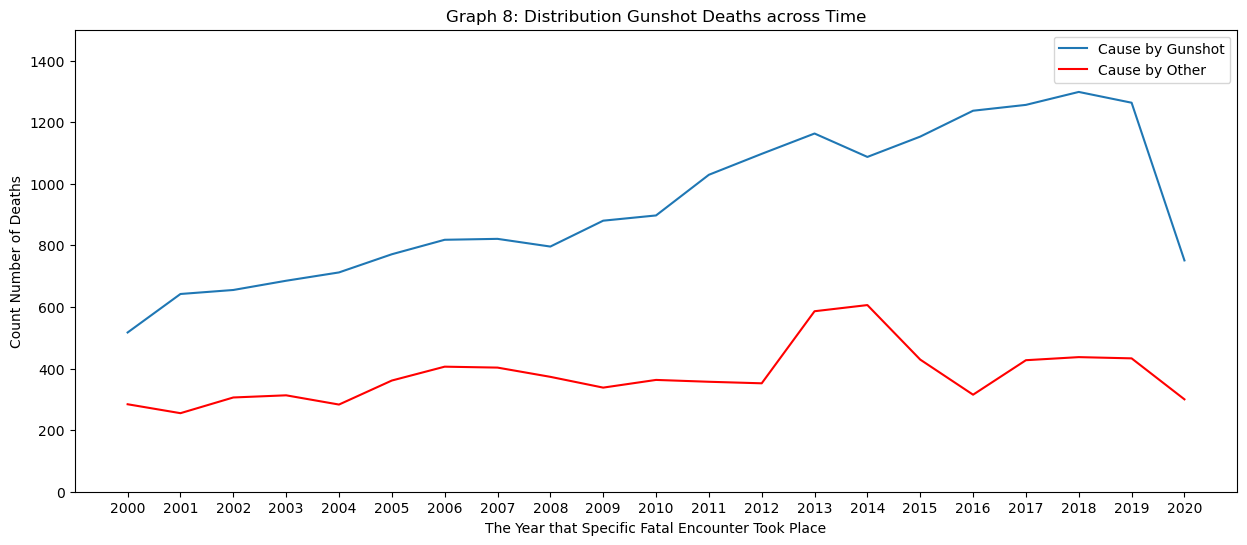

In [21]:
# Summary statistics for Death Distribution by Race and by Type
death_by_year = pd.DataFrame(df.groupby("Year")["Cause_of_death"].value_counts()).rename(
    columns = {"Cause_of_death": "Count"})
death_by_year = death_by_year.reset_index().sort_values(["Year"], ascending = False)

Gunshot_cause = death_by_year[death_by_year["Cause_of_death"] == 1]
Other_cause = death_by_year[death_by_year["Cause_of_death"] == 0]

death_by_year = pd.merge(Gunshot_cause, Other_cause, on = 'Year')
death_by_year = death_by_year.rename(columns = {"Count_x": "Cause by Gunshot", "Count_y": "Cause by Other"}).drop(
    {"Cause_of_death_x", "Cause_of_death_y"}, axis = 1)

Gunshot = death_by_year["Cause by Gunshot"]
Other = death_by_year["Cause by Other"]
Year = death_by_year["Year"]


fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(Year, Gunshot, label = "Cause by Gunshot")
ax.plot(Year, Other, 
        color='red',  
        label = "Cause by Other")

ax.set_xticks(Year)

ax.set_xlabel("The Year that Specific Fatal Encounter Took Place")
ax.set_ylabel("Count Number of Deaths")
ax.set_title("Graph 8: Distribution Gunshot Deaths across Time")

ax.legend()

plt.ylim((0, 1500))

plt.show()

We can extract from Graph 8 that there seems to be no significant rising of deaths for non-gunshot deaths, but indeed there is a rising trend for gunshot deaths. However, what is included in this graph is incomplete. 

First, we should be aware that prior to the year 2013, as indicated by Fatal Encounters researchers, their record of races was "spotty" [2]. In this case, many earlier data that needed significantly more information might have already been eliminated during our data cleaning steps. 

Second, all data collected was from news media. Around twenty years ago, news pressing's ability to collect data and researchers' methods of collecting data were limited. 

Both factors might contribute to the seemingly upward trend of death cases increase. As a result, I still decide to use the data cumulatively rather than further divide it by time. 

In [22]:
df["Coordinates"] = list(zip(df.Longitude, df.Latitude))
df["Coordinates"] = df["Coordinates"].apply(Point)
gdf = gpd.GeoDataFrame(df, geometry = "Coordinates")

Gdeath = gdf[gdf['Cause_of_death'] == 1]
Odeath = gdf[gdf['Cause_of_death'] == 0]

state_df = gpd.read_file("http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_state_5m.zip")

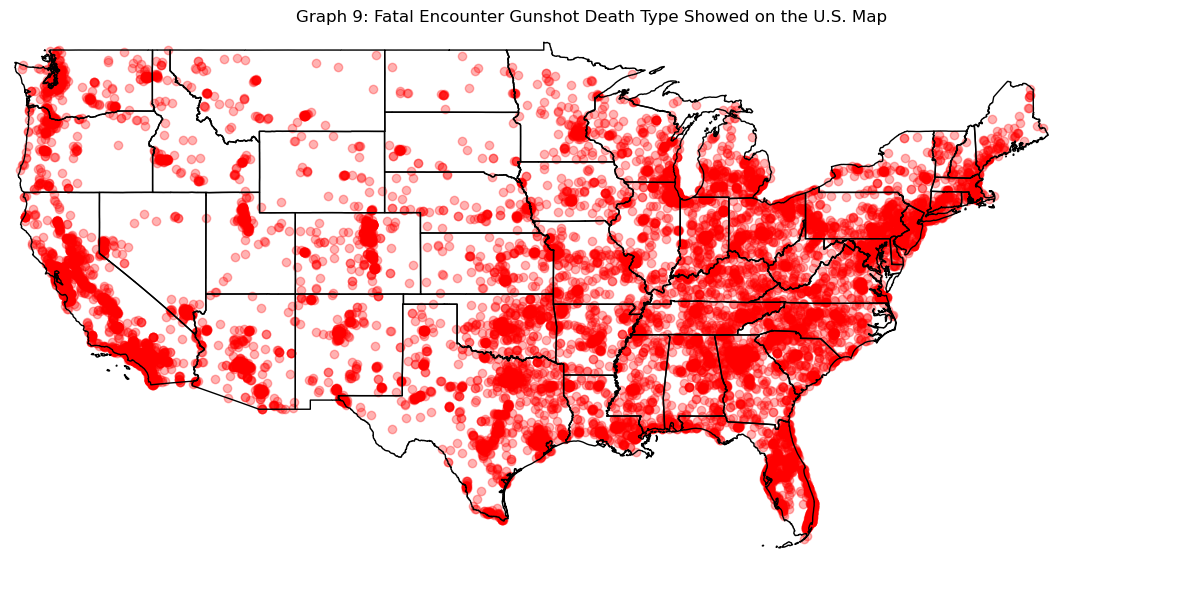

In [23]:
fig, gax = plt.subplots(figsize = (15, 15))

Gdeath.plot(ax = gax, color = 'red', alpha = 0.3)
state_df.plot(ax = gax, edgecolor = "black", color = "none")
plt.ylim(22, 50)
plt.xlim(-125, -60)

gax.set_title('Graph 9: Fatal Encounter Gunshot Death Type Showed on the U.S. Map')

plt.axis('off')

plt.show()

This map demonstrates gunshot deaths in fatal encounters on the United States map. Most deaths were distributed among the East and West coasts, while not many were in the middle states. In this research, we are trying to determine if any features of victims might have a causal relationship with their probability of being killed by guns.

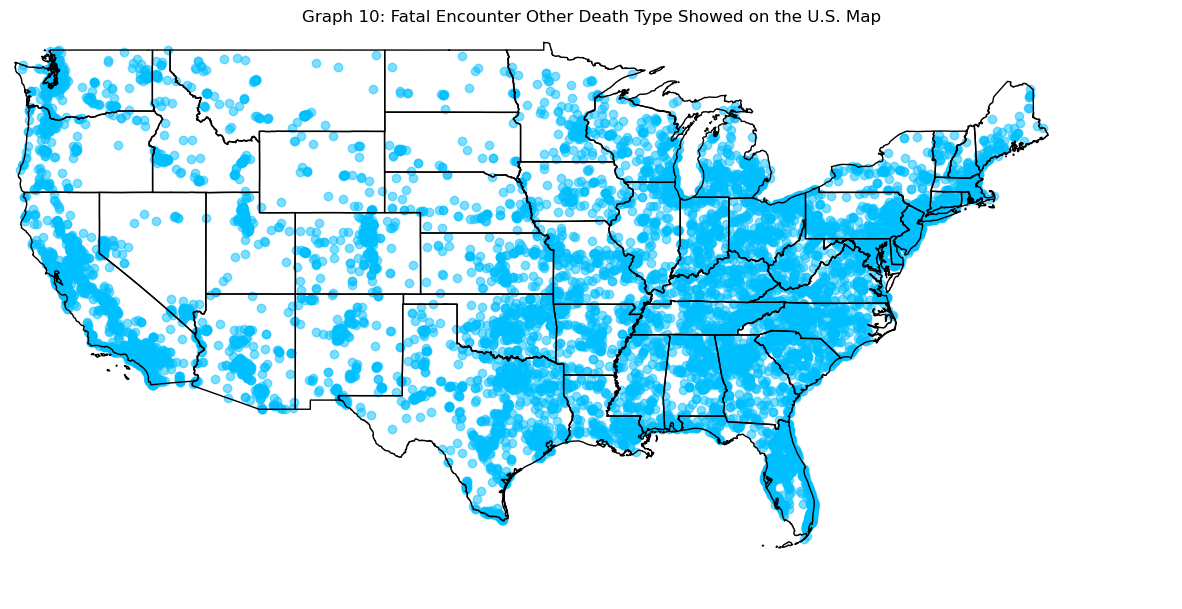

In [24]:
fig, gax = plt.subplots(figsize = (15, 15))

Gdeath.plot(ax = gax, color = 'deepskyblue', alpha = 0.5)
state_df.plot(ax = gax, edgecolor = "black", color = "none")
plt.ylim(22, 50)
plt.xlim(-125, -60)

gax.set_title('Graph 10: Fatal Encounter Other Death Type Showed on the U.S. Map')

plt.axis('off')

plt.show()

This map demonstrates other deaths besides gunshot deaths in fatal encounters on the United States map. Similarly, most deaths were distributed among the East and West coasts. Nevertheless, more deaths are distributed in the middle states compared to the gunshot deaths graph. The number of deaths between a gunshot and other types of deaths was almost equivalent, with a slightly higher number of gunshot deaths.

In [25]:
fig = go.Figure(data = go.Choropleth(
    locations = death_by_state['State'], 
    z = death_by_state['Cause by Gunshot'].astype(float), 
    locationmode = 'USA-states', 
    colorscale = 'Blues',
    colorbar_title = "Death by State"))

fig.update_layout(
    title_text = 'Graph 11: United States Fatal Encounter Death by Gunshot Count by State',
    geo_scope = 'usa')

fig.show()

Now we only take a look at gunshot death distribution in the U.S. The three states with the highest number of deaths are California, Texas, and Florida. This does not seem to provide much new information as these states have the highest population [9]. A state with a higher population and a higher number of fatal encounters might not simultaneously have the highest rate of deaths. Nevertheless, simultaneously, besides California, the other two states do not have a high enough population density, and the number of fatal encounters does not seem to correspond to population density. 

In [26]:
for col in gender_by_state.columns: 
    gender_by_state[col] = gender_by_state[col].astype(str)

gender_by_state['Text'] = gender_by_state['State'] + '<br>' + \
    'Male ' + gender_by_state['Male'] + '<br>' + \
    'Female ' + gender_by_state['Female'] + '<br>' + \
    'Transgender ' + gender_by_state['Transgender']

fig = go.Figure(data = go.Choropleth(
    locations = gender_by_state['State'], 
    z = gender_by_state['Male'].astype(float), 
    locationmode = 'USA-states', 
    colorscale = 'Greens',
    text = gender_by_state['Text'],
    colorbar_title = "Death by State"))

fig.update_layout(
    title_text = 'Graph 12: United States Fatal Encounter Death by Gunshot Count by Male by State',
    geo_scope = 'usa')

fig.show()

Surprisingly, no matter which state, males constantly have an overwhelmingly higher number of gunshot deaths than females. Except for the transgender population, which takes a relatively tiny proportion of the whole population compared to females and males, the male and female proportions should be relatively the same. However, in many states, male deaths during fatal gunshot encounters are more than twice that of female deaths. The gender factor seems to be irrelevant to the location factor. Additionally, regarding the number of gunshot deaths, although the map only illustrates male deaths, the distribution simulates that of the all-gender death map. 

In [27]:
fig = px.choropleth(
    locations = race_by_state['State'], 
    locationmode = "USA-states", 
    color = race_by_state['Max'],
    scope = "usa")

fig.update_layout(
    title_text = 'Graph 13: United States Races which Faced the Greatest Number of Gunshot Death by State',
    geo_scope = 'usa')

fig.show()

This map illustrates the race with the highest number of gunshot deaths with police presence in each state. For most states, the races of victims seem irrelevant to the state. This is because the white population is more than twice as many as any other race population, so they should not surprise us when we see that most states have white people to be killed the most. 

However, there are several deviates. West states, California and New Mexico have the most Hispanic/Latino people killed. For New York, Maryland, New Jersey, Illinois, Georgia, and Louisiana, the number of African-American/Black victims outweighs other race populations. These are all states on the east side of the U.S. Finally, in Hawaii, Asians/Pacific Islanders have the most got killed. 

# Project 3

## Potential Data to Scrape

Because the primary purpose of this research is to investigate any association between one person's chance of dying from a gunshot police fatal encounter and this person's gender, race, and location, an ideal scraped dataset is likely to supplement information regarding this topic. Right now, based on my original dataset, what I lack significantly is information related to the situation of each state. 

I incorporate state as one of my predictors because geographical location can represent an approximate wealth situation, race/ethnicity group population distribution, climate situation, production structure, and so on. However, if I want to investigate the influence of income on the chance of facing violence directly, I would better include a dataset about income in my analysis.

In addition, as I have emphasized above, my maps and graphs related to the total number of gunshot deaths and gunshot deaths distributed among different races can reveal a biased result because many cases can be pure because of the high proportion of a particular population. For example, suppose the white population takes up to 70% of the U.S. population. In that case, there is no doubt that most cases will occur among white people unless there are extreme cases in which one or more specific races face mistreatment and discrimination during police actions.

For this part, I will first use HTML-based web scraping to acquire a dataset related to average state incomes [10]. In particular, I will focus on per-capita income, which can avoid influence from population factors. This can be either a supplement or a substitute for the indicator state. It focuses on one specific aspect that geographic information can reflect rather than a mix of multiple factors. 

For basic analysis via visualizations, we can use a barplot and a U.S. map to reflect the average per-capita income for each state. Subsequently, we can compare the color of the income map with the gunshot death cases map and briefly see if there is any connection between these two maps. For example, we might expect poorer regions to experience more violence; conversely, more prosperous regions are likely to have more death cases because these regions tend to have a higher population density.

In order to use this scraped dataset for further analysis, I will merge this income dataset with the original fatal encounter dataset on the variable "State." We can consider using the average per-capita income to represent the income of each victim and add this variable to our regression model. Although this is not the perfect approach because victim's income might not be accurately reflected upon by the state's average income, we have no better choice. The Fatal Encounter did not collect any salary data. 

Suppose we see any significant association between the chance of facing a gunshot and victims' income. In that case, it can also help to conclude that victims' location can significantly influence their chance of facing violence, as we use the average income level in each state. However, to avoid homoscedasticity issues, I will not simultaneously add the indicator state and the indicator income to my regression model. I will run two separate regressions, one with each indicator. The model with the variable state can have a general appearance of geographical influence, and the model with the variable income focuses specifically on geographic wealth distribution. 

## Potential Challenges

Technically speaking, the web scraping process was smooth sailing for me during this attempt. I could efficiently access the source code of websites, and Wikipedia permits the use of information obtained through web scraping for personal use. A more challenging aspect for me was determining the accuracy of the information I obtained from Wikipedia. This website is typically deemed unsuitable for citation in scholarly writing due to its editable nature by any user.

Fortunately, Wikipedia was one of many websites I searched during my information-hunting process. I initially discovered a primary source from the U.S. Census Bureau. Subsequently, I found that the Wikipedia source reproduced the census data, presenting it in a more organized and accessible tabular format. As a result, having located the primary source material, I proceeded to scrape the Wikipedia table as it is in a tidy version that is easier for data cleaning and merging and incorporate it into my research.

## Scraping Data from a Website

In [28]:
# Get the url for per-capita income
income_url = 'https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_income'
income_response = requests.get(income_url)
income_soup_object = BeautifulSoup(income_response.content)
# Choose the correct index of the table
income_data_table = income_soup_object.find_all('table', 'wikitable')[2]
# Work through the table through table rows (tr)
income_values = income_data_table.find_all('tr')

In [29]:
# Build up an empty dataset
income_df = pd.DataFrame(columns = ['Rank', 'State', 'Per_Capita_2019', 'Per_Capita_2020'])
ix = 0

# Write a for loop and look for each table value
# I did not scrape the entire table. I only want to use the 2020 per-capita income column
for row in income_values[1:]:
    values = row.find_all('td')
    rank = values[0].text.split('\n')[0]
    state = values[1]
    per_capita_2019 = values[2].text.split('\n')[0]
    per_capita_2020 = values[3].text.split('\n')[0]
    
    income_df.loc[ix] = [rank, state, per_capita_2019, per_capita_2020]
    ix += 1
    
# Drop columns that I do not need
income_df = income_df.drop(0).reset_index().drop({"index", "Rank", "Per_Capita_2019"}, axis = 1)
# Drop the dollar sign.
income_df["Per_Capita_2020"] = income_df.Per_Capita_2020.apply(lambda x: x.replace('$', ''))

In [30]:
# Change the state value into abbreviations in order to merge with the original dataset
income_states = ['DC', 'MA', 'CT', 'NJ', 'MD', 'NY', 'WA', 'NH', 'CO', 'VA', 'CA', 'MN', 'IL', 'RI', 'HI', 'AK', 
                 'DE', 'ND', 'PA', 'VT', 'OR', 'WI', 'WY', 'ME', 'NV', 'NE', 'IA', 'MI', 'FL', 'KS', 'OH', 'GA', 
                 'MT', 'TX', 'AZ', 'NC', 'UT', 'MO', 'SD', 'SC', 'TN', 'IN', 'OK', 'ID', 'KY', 'LA', 'AL', 'NM', 
                 'WV', 'AR', 'MS', 'VI', 'GU', 'PR', 'MP', 'AS']
income_df['State'] = income_states
income_df = income_df.drop([51, 52, 53, 54, 55])

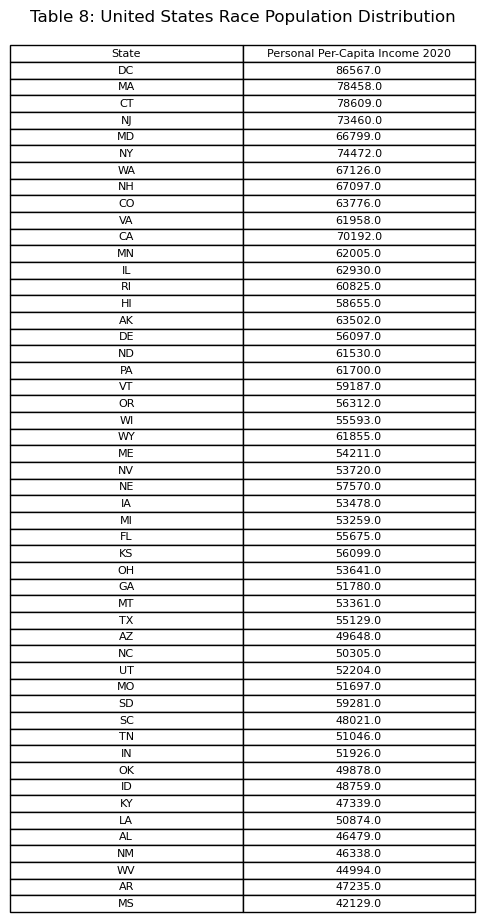

In [31]:
# Use the for loop to change the type of column values into float. 
for column in income_df.columns[1:]:
    income_df[column] = income_df[column].str.replace(',', '').astype(float)

# Present the scraped dataset into a nicely formatted matplotlib table
income_distribution = income_df
income_distribution = income_distribution.rename(columns = {"Per_Capita_2020": "Personal Per-Capita Income 2020"})

fig = plt.figure(figsize = (6, .2))
ax = fig.add_subplot(111)

ax.table(cellText = income_distribution.values, colLabels = income_distribution.columns, cellLoc = 'center')
ax.set_title("Table 8: United States Race Population Distribution")
ax.axis('off')

plt.show()

## Merging the Scraped Dataset

In [32]:
df_with_income = pd.merge(df, income_df, on = 'State', how = "outer").dropna()

Before I merge the scraped dataset with the original dataset, the original dataset contains 26937 rows. After merging with the scraped dataset, the row number does not change and continues to be 26937 observations.

## Adding a New Dataset

One issue with the fatal encounter dataset is the lack of information regarding the specific states where the incidents occurred. It may be worthwhile to consider incorporating descriptive information about the states to supplement my data analysis. Through preliminary data visualization, we can observe that most deaths due to police shootings are concentrated in certain states along the West coast of the United States. However, this may be attributed to the significantly larger populations in some states than others, which could result in a higher number of overall cases even if the proportion of deaths is not high.

For example, our analysis reveals that in most states, white individuals are the largest racial group among gunshot victims. However, considering the previously mentioned factors, although the United States is a melting pot, the white population constitutes the majority. Consequently, upon calculating the fatalities, the group with the highest number of deaths may not necessarily be white individuals, even though they represent the largest number of victims. This is why it is crucial to incorporate data on state populations and the number of individuals from various racial groups in each state [11].

Similarly, the data is sourced from the U.S. Census Bureau. I scraped the neatly formatted table on Wikipedia for convenience in subsequent data merging, ensuring the data source remains credible.

In [33]:
# Get the url for race demographic
race_url = 'https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_race/ethnicity'
race_response = requests.get(race_url)
race_soup_object = BeautifulSoup(race_response.content)
# Choose the correct index of the table
race_data_table = race_soup_object.find_all('table', 'wikitable')[0]
# Work through the table through table rows (tr)
race_values = race_data_table.find_all('tr')

In [34]:
# Build up an empty dataset
census_df = pd.DataFrame(columns = ['State', 'Population', 'Euro_American_White', 
                                    'Euro_American_White_percent', 'Afri_American_Black', 
                                    'Afri_American_Black_percent', 'Native_Alaskan', 
                                    'Native_Alaskan_percent', 'Asian', 'Asian_percent', 'Pacific_Islander', 
                                    'Pacific_Islander_percent', 'Other_Race', 'Other_Race_percent', 'Mixed_Race', 
                                    'Mixed_Race_percent', 'Hispanic_Latino', 'Hispanic_Latino_percent'])
ix = 0

# Use a for loop to extract table cell values
for row in race_values[1:]:
    values = row.find_all('td')
    state = values[0]
    total = values[1].text.split('\n')[0]
    white = values[2].text.split('\n')[0]
    white_percent = values[3].text.split('\n')[0]
    black = values[4].text.split('\n')[0]
    black_percent = values[5].text.split('\n')[0]
    native = values[6].text.split('\n')[0]
    native_percent = values[7].text.split('\n')[0]
    asian = values[8].text.split('\n')[0]
    asian_percent = values[9].text.split('\n')[0]
    pacific = values[10].text.split('\n')[0]
    pacific_percent = values[11].text.split('\n')[0]
    other = values[12].text.split('\n')[0]
    other_percent = values[13].text.split('\n')[0]
    mixed = values[14].text.split('\n')[0]
    mixed_percent = values[15].text.split('\n')[0]
    hispanic = values[16].text.split('\n')[0]
    hispanic_percent = values[17].text.split('\n')[0]
    
    census_df.loc[ix] = [state, total, white, white_percent, black, black_percent, native, native_percent, 
                                 asian, asian_percent, pacific, pacific_percent, other, other_percent, mixed, 
                                 mixed_percent, hispanic, hispanic_percent]
    ix += 1

In [35]:
wiki_states = ['U.S. 50 states and D.C.', 'U.S. 50 states, D.C., and Puerto Rico', 'AL', 'AK', 'AZ', 'AR', 'CA', 
               'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 
               'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 
               'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'AS', 'GU', 'MP', 'PR', 'VI']
# Replace state value with my self-built list for convenience of dataset merging later
census_df['State'] = wiki_states
# Drop columns that I do not need for my analysis and visualizations
census_df = census_df.drop({"Euro_American_White_percent", "Afri_American_Black_percent", 
                            "Native_Alaskan_percent", "Asian_percent", "Pacific_Islander_percent", 
                            "Other_Race_percent", "Mixed_Race_percent", "Hispanic_Latino_percent"}, axis = 1)
census_df = census_df.drop([1, 53, 54, 55, 56, 57]).reset_index().drop({"index"}, axis = 1)

for column in census_df.columns[1:]:
    census_df[column] = census_df[column].str.replace(',', '').astype(float)

census_df["Asian_Pacific_Islander"] = census_df["Asian"] + census_df["Pacific_Islander"]
census_df["Other"] = census_df["Other_Race"] + census_df["Mixed_Race"]
census_df = census_df.drop({'Asian', 'Pacific_Islander', 'Other_Race', 'Mixed_Race'}, axis = 1)

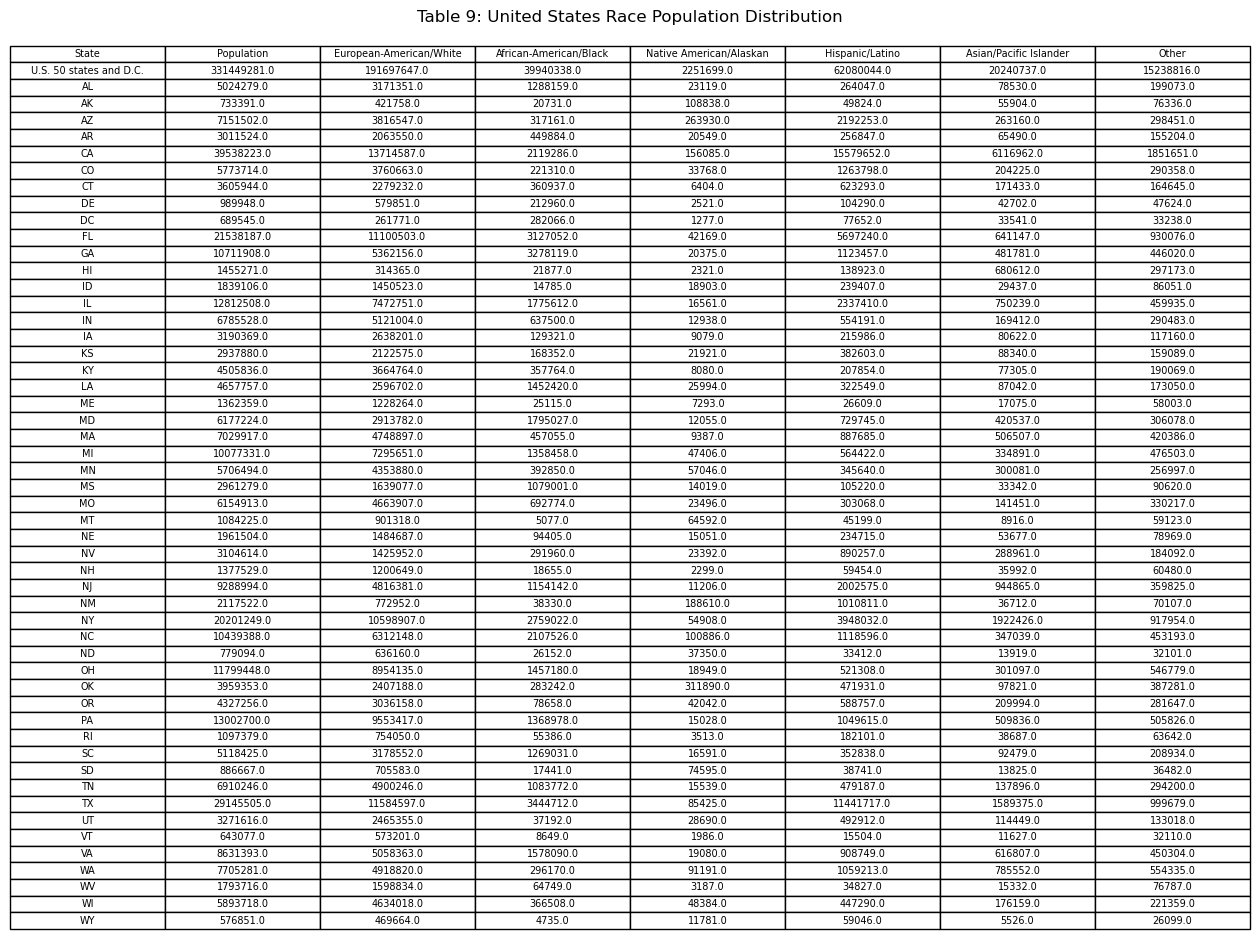

In [36]:
race_distribution = census_df
race_distribution = race_distribution.rename(columns = {"Euro_American_White": "European-American/White", 
                                                        "Afri_American_Black": "African-American/Black", 
                                                        "Native_Alaskan": "Native American/Alaskan", 
                                                        "Hispanic_Latino": "Hispanic/Latino", 
                                                        "Asian_Pacific_Islander": 'Asian/Pacific Islander'})

fig = plt.figure(figsize = (16, .2))
ax = fig.add_subplot(111)

ax.table(cellText = race_distribution.values, colLabels = race_distribution.columns, cellLoc = 'center')
ax.set_title("Table 9: United States Race Population Distribution")
ax.axis('off')

plt.show()

In [37]:
final_df = pd.merge(df_with_income, census_df, on = 'State', how = "outer").dropna()

After merging with the new dataset, the total number of observations remains 26937, which does not change from the previous merging result. 

## Visualizing the Scraped Dataset

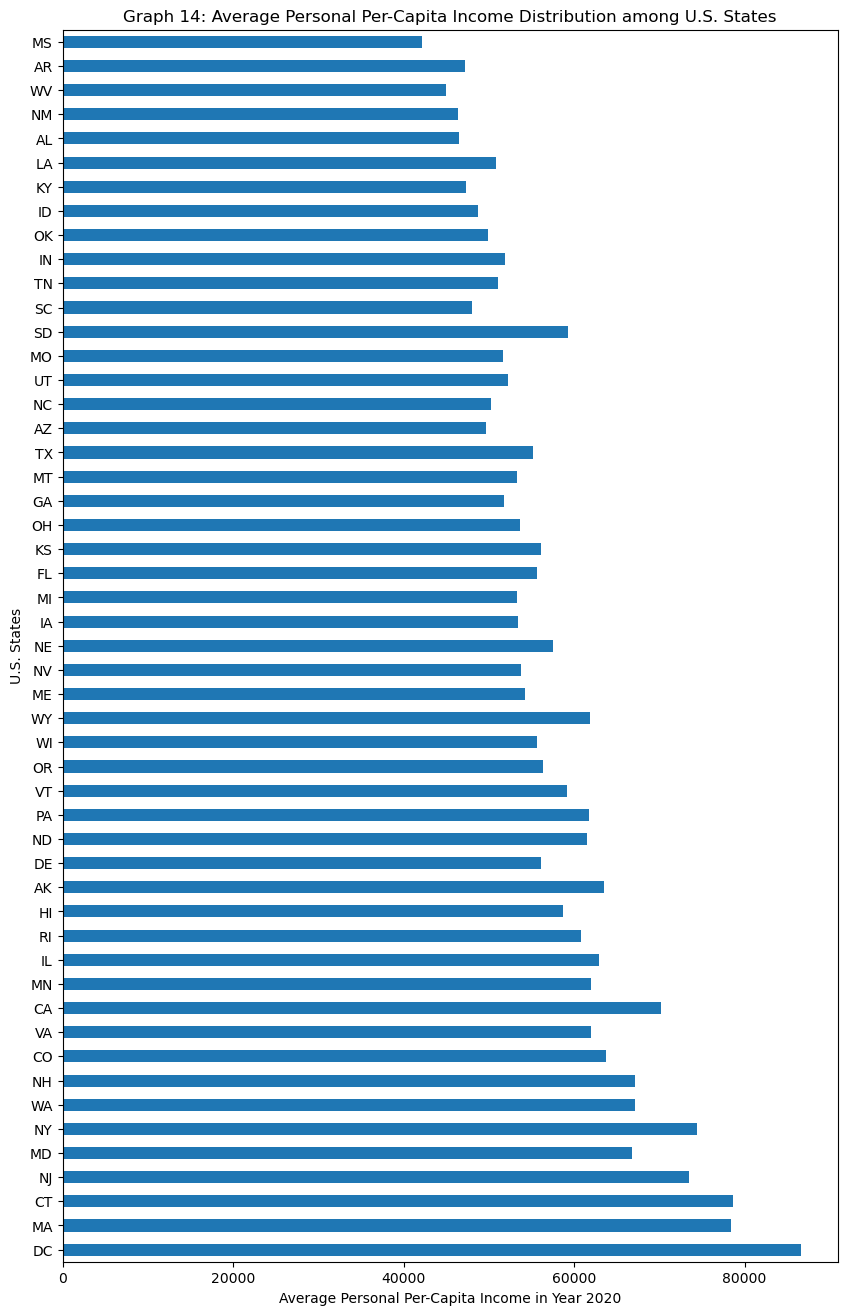

In [38]:
# Per-Capita Income Distribution by State 
ax = income_df.plot(kind = 'barh', x = 'State', y = 'Per_Capita_2020', figsize = (10, 16), legend = False)

ax.set_ylabel('U.S. States')
ax.set_xlabel('Average Personal Per-Capita Income in Year 2020')
ax.set_title('Graph 14: Average Personal Per-Capita Income Distribution among U.S. States')

plt.show()

Graph 14 is derived from the data obtained through the first web scraping exercise, which pertains to the average per-capita income across various states in the United States. As observed from the bar plot, there can be significant disparities in income levels among states. For instance, the per-capita income in Washington, D.C., is more than twice that of Mississippi. This highlights the importance of considering the state as an indicator, as it encompasses a wealth of information, including income levels.

In [39]:
fig = go.Figure(data = go.Choropleth(
    locations = income_distribution['State'], 
    z = income_distribution['Personal Per-Capita Income 2020'].astype(float), 
    locationmode = 'USA-states', 
    colorscale = 'Purples',
    colorbar_title = "Per-Capita Income by State"))

fig.update_layout(
    title_text = 'Graph 15: Average Per-Capita Income Distribution by State',
    geo_scope = 'usa')

fig.show()

Graph 15 presents the barplot above more intuitively by displaying the information on a map. We can observe that states with higher incomes are primarily concentrated along the East and West coasts of the United States, with these regions generally exhibiting darker shades on the map. Notably, the higher number of fatalities along the West Coast and in the South does not appear to be directly correlated with income levels. Assuming that higher-income areas experience less violence, the West Coast region would exhibit the highest violent incidents. Conversely, if higher-income areas experience more violence, the East Coast region would exhibit darker shades in Graph 11. Consequently, it is evident that in addition to income, other factors are encapsulated within the state indicator that influences the number of fatalities resulting from police shootings.

In [40]:
# Calculate the proportion of gunshot deaths over the population of each state
population_index = pd.merge(race_distribution, death_by_state, on = 'State', how = "outer").dropna()
population_index["Index(%)"] = 100 * (population_index["Cause by Gunshot"] / population_index["Population"])

In [41]:
fig = go.Figure(data = go.Choropleth(
    locations = population_index['State'], 
    z = population_index['Index(%)'].astype(float), 
    locationmode = 'USA-states', 
    colorscale = 'Blues',
    colorbar_title = "Gunshot Proportion Index"))

fig.update_layout(
    title_text = 'Graph 16: United States Fatal Encounter Death by Gunshot Ratio by State',
    geo_scope = 'usa')

fig.show()

Graph 16 displays the proportion of deaths resulting from police-involved shootings in each state. Unlike Graph 11, which shows the highest number of fatalities in California, Texas, and Florida, when the population data of each state is incorporated to calculate the death rate (i.e., the number of deaths per capita), the highest mortality rates are primarily concentrated in several states in the central United States, as well as Alaska. This underscores the importance of considering the state as an indicator. The varying population sizes across states can significantly impact the likelihood of an individual falling victim to lethal police violence.

In [42]:
# Align the variable names for the original data and the scraped data
race_by_state = race_by_state.rename(columns = {"Middle Eastern": "Other"}).drop({"Max"}, axis = 1)
race_distribution = race_distribution.rename(columns = {"European-American/White": "White Population", 
                                                        "African-American/Black": "Black Population", 
                                                        "Native American/Alaskan": "Native Population", 
                                                        "Hispanic/Latino": "Latino Population", 
                                                        "Asian/Pacific Islander": "Asian Population", 
                                                        "Other": "Other Population"})

In [43]:
race_index = pd.merge(race_by_state, race_distribution, on = 'State', how = "outer").dropna()
race_index["White Index(%)"] = 100 * (race_index["European-American/White"] / race_index["White Population"])
race_index["Black Index(%)"] = 100 * (race_index["African-American/Black"] / race_index["Black Population"])
race_index["Latino Index(%)"] = 100 * (race_index["Hispanic/Latino"] / race_index["Latino Population"])
race_index["Asian Index(%)"] = 100 * (race_index["Asian/Pacific Islander"] / race_index["Asian Population"])
race_index["Native Index(%)"] = 100 * (race_index["Native American/Alaskan"] / race_index["Native Population"])
race_index["Other Index(%)"] = 100 * (race_index["Other"] / race_index["Other Population"])
race_index = race_index.drop({"European-American/White", "African-American/Black", "Hispanic/Latino", 
                              "Asian/Pacific Islander", "Native American/Alaskan", "Other", "Population", 
                              "White Population", "Black Population", "Native Population", "Latino Population", 
                              "Asian Population", "Other Population"}, axis = 1)
race_indexMax = race_index.drop({"State"}, axis = 1)
maxIndex = race_indexMax.idxmax(axis=1)
race_index["Max"] = maxIndex

In [44]:
fig = px.choropleth(
    locations = race_index['State'], 
    locationmode = "USA-states", 
    color = race_index['Max'],
    scope = "usa")

fig.update_layout(
    title_text = 'Graph 17: United States Races with the Greatest Proportion of Gunshot Death by State',
    geo_scope = 'usa')

fig.show()

Graph 16 also highlights the importance of incorporating population data into the analysis. As previously emphasized, most of the United States population consists of white individuals, which could likely explain why in Graph 13, the highest fatalities are among white individuals in many states. However, upon calculating the death rate for each racial group, it becomes evident in Graph 16 that the highest mortality rates are predominantly among black individuals in the vast majority of states. In some northern states, Native Americans exhibit the highest death rates, whereas only in New Mexico do white individuals have the highest mortality rate. Therefore, after adjusting for the population sizes of each racial group, a more apparent association between the victims' race and fatalities resulting from police-involved shootings can be observed.

# Final Project

## Economic Intuition

We do not need to assume a linear data distribution in logistic regression models. However, we do assume a linear relationship between the logit of the probability of the outcome and the predictor variables. In the context of this study, the outcome is whether the victim died from a gunshot, a binary variable, and the predictor variables are Gender, Race, and State (which can be replaced by the Population of each state and the average per-capita Income of each state). The logit function helps transform a logistic regression problem into a linear one.

Subsequently, I conducted another secondary research study examining the relationships between the number of fatalities in police-involved shootings and other police-involved fatal incidents across all U.S. states and various demographic and socioeconomic factors. These factors include the average per-capita income in the year 2020, the populations of European-American/White, African-American/Black, Native American/Alaskan, Hispanic/Latino, Asian/Pacific Islander, other race/ethnicity groups, and the male population. This study employed Ordinary Least Squares (OLS) regression models to analyze these relationships. The existing literature has already demonstrated the linear relationships between each independent variable and dependent variable pair. However, the primary difference between the previous model and the current one is the unit of observation. The former model focused on each victim as an individual observational unit. In contrast, the current model aggregates the number of victims per state and utilizes each state as an observational unit. Consequently, the methodology transitioned from a logistic regression model to a linear regression model.

Many economists believe socioeconomic status (SES) is crucial in determining access to resources, including education and healthcare. In their book Socioeconomic Inequality and Educational Outcomes, Broer et al. mentioned that scholars and policymakers have long studied the relationship between SES and educational achievement, striving to reduce the educational outcome gaps caused by SES disparities [1]. The prevailing view in the Trends in International Mathematics and Science Study (TIMSS) is that there is a positive relationship between SES and educational outcomes. Building on this premise, SES differences arising from potential gender/race discrimination could further impact some individuals' educational outcomes, subsequently affecting their well-being and risk of victimization. Regarding health problems, Steptoe and Zaninotto found that SES is a decisive factor in many health issues for older populations, with less affluent individuals aging faster than their privileged counterparts [7]. Rahman et al. discovered that in the context of an unexpected large-scale health and economic crisis like COVID-19, low-income populations in Sichuan Province, China, are more vulnerable to poverty due to their reliance on agricultural income and government transfer payments [6]. The existing SES disparities, likely attributable to gender/race inequality, may exacerbate inequality in education, healthcare, and other outcomes, as well as differing resilience, potentially leading to increased crime or violence.

## Independent Variable Explanations

As Lang and Spitzer mentioned, discriminatory attitudes from employers, colleagues, and potential customers could result in unequal market outcomes [5]. These factors might make it more challenging for specific gender/race groups to succeed in the labor market or result in lower income levels. Lower-income individuals may be more likely to become involved in crime or live in more dangerous neighborhoods. They also mentioned that discrimination could exist in the criminal justice system, including police actions and court decisions. As the subjects of this study have all passed away, this might have led to a particular bias in the distribution of gender/race within the population. Furthermore, as a more severe form of mortality, gunshot deaths may also differ across genders and races.

When comparing the compositions of the independent variables between the two research models, the first logistic regression model utilizes a binary variable representing whether each victim was fatally shot as the response variable. The long model includes the victim's gender, race, the state in which they died, and the average per-capita income in the year 2020 for their state as a proxy for their income (recognizing that this may have some discrepancy with the actual income of each victim, but this is due to the lack of income data in the original dataset). Furthermore, it accounts for the state's overall population and the populations of European-American/White, African-American/Black, Native American/Alaskan, Hispanic/Latino, Asian/Pacific Islander, and other race/ethnicity groups. A final model is obtained by comparing the variable coefficients' p-values and examining the variance inflation factor (VIF) data to address multicollinearity issues.

In contrast with the first research model, the second model's response variable is no longer at the individual level but at the state level. Besides this change, the model includes the aforementioned racial and ethnic populations for each state, the average per-capita income in 2020, and the number of male residents in each state.

Determining the relationship between the Cause of Death and Gender, Race, and State through qualitative/empirical studies alone is challenging and might be unreliable. Further research and statistical analysis are necessary to understand and validate the relationship between these variables.

## OLS Regressions

In [45]:
final_df['Population'] = final_df['Population'].astype(float)
final_df['Per_Capita_2020'] = final_df['Per_Capita_2020'].astype(float)
final_df['Euro_American_White'] = final_df['Euro_American_White'].astype(float)
final_df['Afri_American_Black'] = final_df['Afri_American_Black'].astype(float)
final_df['Native_Alaskan'] = final_df['Native_Alaskan'].astype(float)
final_df['Hispanic_Latino'] = final_df['Hispanic_Latino'].astype(float)
final_df['Asian_Pacific_Islander'] = final_df['Asian_Pacific_Islander'].astype(float)
final_df['Other'] = final_df['Other'].astype(float)
final_df = final_df.rename(columns = {"Cause_of_death": "Cause of Death"})

In [46]:
final_df['Population'] = final_df['Population'] / 10000
final_df['Euro_American_White'] = final_df['Euro_American_White'] / 10000
final_df['Afri_American_Black'] = final_df['Afri_American_Black'] / 10000
final_df['Native_Alaskan'] = final_df['Native_Alaskan'] / 10000
final_df['Hispanic_Latino'] = final_df['Hispanic_Latino'] / 10000
final_df['Asian_Pacific_Islander'] = final_df['Asian_Pacific_Islander'] / 10000
final_df['Other'] = final_df['Other'] / 10000

In [47]:
# Model 1
y = final_df['Cause of Death']

formula1 = 'y ~ C(Gender) + C(Race, Treatment("European-American/White")) + Per_Capita_2020'
y, X = patsy.dmatrices(formula1, final_df)

model1 = sm.OLS(y, X).fit(disp = 0)

In [48]:
# Model 2
formula2 = 'y ~ C(Gender) + C(Race, Treatment("European-American/White")) + Population'

y, X = patsy.dmatrices(formula2, final_df)

model2 = sm.OLS(y, X).fit(disp = 0)

In [49]:
# Model 3
formula3 = 'y ~ C(Gender) + C(Race, Treatment("European-American/White")) + Per_Capita_2020 + Population'

y, X = patsy.dmatrices(formula3, final_df)

model3 = sm.OLS(y, X).fit(disp = 0)

In [50]:
# Create a summary table
summary_table = summary_col(
    [model1, model2, model3],
    model_names = ["Model 1", "Model 2", "Model 3"],
    stars = True,
    float_format = "%.2f",
    info_dict = {
        "N": lambda x: f"{int(x.nobs):,}",
        "R2": lambda x: f"{x.rsquared:.2f}",
    },
)
summary_table.title = "Table 9: Regression Results: Cause of Death by Gunshot during Fatal Encounters"

In [51]:
# Extract the table data
table_data = summary_table.tables[0]

# Create a new DataFrame with the desired column names and index
df = pd.DataFrame(table_data, columns = ["Model 1", "Model 2", "Model 3"])

# Rename the index
new_param_names = {
    "Intercept": "Intercept",
    "C(Gender)[T.Male]": "Male",
    "C(Gender)[T.Transgender]": "Transgender",
    "C(Race, Treatment(\"European-American/White\"))[T.Asian/Pacific Islander]": "Asian/Pacific Islander",
    "C(Race, Treatment(\"European-American/White\"))[T.African-American/Black]": "African-American/Black",
    "C(Race, Treatment(\"European-American/White\"))[T.Hispanic/Latino]": "Hispanic/Latino",
    "C(Race, Treatment(\"European-American/White\"))[T.Middle Eastern]": "Middle Eastern",
    "C(Race, Treatment(\"European-American/White\"))[T.Native American/Alaskan]": "Native American/Alaskan",
    "C(Race, Treatment(\"European-American/White\"))[T.Race unspecified]": "Race unspecified",
    "Per_Capita_2020": "Per Capita Income in 2020",
    "Population": "Population",
    "R2": "R2",
    "N": "N",
}

df.index = df.index.to_series().replace(new_param_names)

# Add a row for standard errors
df.loc["Standard errors in parentheses."] = ""

# Add a row for significance levels
df.loc["* p<.1, ** p<.05, ***p<.01"] = ""

# Print the table as an HTML table
html_table = df.to_html(classes = "table table-bordered", header = True, index = True)

# Add the title, and formatting
html_output = f"""
<!DOCTYPE html>
<html>
<head>
<style>
table {{
    font-family: Arial, sans-serif;
    border-collapse: collapse;
    width: 100%;
}}
td, th {{
    border: 1px solid #dddddd;
    text-align: left;
    padding: 8px;
}}
th {{
    background-color: #f2f2f2;
}}
</style>
</head>
<body>

<h2>Table 10: Regression Results: Cause of Death by Gunshot during Fatal Encounters</h2>
{html_table}

</body>
</html>
"""

# Display the output
display(HTML(html_output))

Table 10 presents the results of three logistic regression models predicting the likelihood of a victim dying from a gunshot versus dying from other causes. In all three models, the independent variables include Gender with three levels (Female - base level, Male, and Transgender) and Race with seven levels (European-American/White - base level, Asian/Pacific Islander, African-American/Black, Hispanic/Latino, Middle Eastern, Native American/Alaskan, and Race unspecified).

In Model 1, the only additional independent variable included is Per Capita Income in 2020, a continuous variable representing each U.S. state's average per-capita income in 2020. In Model 2, the Population variable is added, representing the total population of each U.S. state. Model 3 includes Per Capita Income in 2020 and Population as independent variables.

The R-squared and adjusted R-squared values are consistent across all three models at 0.05, indicating that approximately 5% of the variation in the dependent variable (death by gunshot or other) can be explained by the independent variables in each model.

Across all three models, the coefficients for Males and Transgender are positive and statistically significant at the 1% and 10% levels, respectively. This suggests that, compared to the base level (Female), being Male or Transgender is associated with a higher likelihood of death by gunshot. The coefficients for African-American/Black, Native American/Alaskan, and Race unspecified are negative and significant at the 1%, 5%, and 1% levels, respectively, indicating that these groups are less likely to die by gunshot compared to the base level (European-American/White). The coefficients for Asian/Pacific Islander, Hispanic/Latino, and Middle Eastern are not statistically significant, indicating no meaningful difference in the likelihood of death by gunshot compared to the base level.

The addition of the Per Capita Income in 2020 (Model 1) and Population variable (Model 2) does not meaningfully change the coefficients, standard errors, or model fit (R-squared and adjusted R-squared) compared to the base model (Model 3) which includes both variables. In all models, the coefficients for Per Capita Income in 2020 and Population are not statistically significant, indicating that these variables do not significantly contribute to predicting whether a victim died from a gunshot or other causes.

In [52]:
final_df['Gender'] = final_df['Gender'].astype('category').cat.codes
final_df['Race'] = final_df['Race'].astype('category').cat.codes
final_df['State'] = final_df['State'].astype('category').cat.codes

In [53]:
def remove_high_vif(X, vif_threshold = 10):
    vif = pd.DataFrame()
    vif["variable"] = X.columns
    vif["vif"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    high_vif_columns = vif[vif["vif"] > vif_threshold]["variable"].tolist()
    X_reduced = X.drop(high_vif_columns, axis = 1)

    return X_reduced

def backward_stepwise_selection(y, X, significance_level = 0.05):
    predictors = list(X.columns)
    best_AIC = np.inf

    while True:
        X_with_constant = sm.add_constant(X[predictors])
        model = sm.Logit(y, X_with_constant)
        results = model.fit(disp = 0)

        p_values = results.pvalues.drop("const")
        max_p_value_predictor = p_values.idxmax()

        if p_values[max_p_value_predictor] > significance_level:
            predictors.remove(max_p_value_predictor)
            X_with_constant = sm.add_constant(X[predictors])
            model = sm.Logit(y, X_with_constant)
            results = model.fit(disp = 0)
        else:
            break

    return results, predictors

y4 = final_df['Cause of Death']
X4 = final_df[['Gender', 'Race', 'State', 'Per_Capita_2020', 'Population', 'Euro_American_White', 
               'Afri_American_Black', 'Native_Alaskan', 'Hispanic_Latino', 'Asian_Pacific_Islander', 'Other']]

X4_reduced = remove_high_vif(X4)
final_results, final_predictors = backward_stepwise_selection(y4, X4_reduced)

# Create stargazer table
stargazer = Stargazer([final_results])
stargazer.title("Table 11: Final Model Derived from the Full Model with Cause of Death as the Response Variable")
stargazer.custom_columns(["Backward Stepwise Selection"], [1])

# Display the stargazer table as an HTML table
HTML(stargazer.render_html())

Table 11 presents the results of a logistic regression model with the dependent variable "Cause of Death," a binary variable indicating whether a victim died from a gunshot or other causes. The long model includes Gender (with three levels: Female as the base level, Male, and Transgender), Race (with seven levels: European-American/White as the base level, Asian/Pacific Islander, African-American/Black, Hispanic/Latino, Middle Eastern, Native American/Alaskan, and Race unspecified), State (with fifty levels, representing all U.S. states), Per_Capita_2020 (a continuous variable indicating the average per-capita income in 2020 for each U.S. state), Population (a continuous variable representing the total population of each U.S. state), and various racial and ethnic population categories within each state.

The presented results are obtained after performing a backward stepwise selection based on the p-values of the coefficients. Multicollinearity issues have been checked and addressed during the selection process.
In the final model, Gender shows a positive and significant association with the likelihood of dying from a gunshot, with an estimated coefficient of 1.473 and a p-value of less than 0.01. This suggests that the odds of dying from a gunshot increase with the levels of the Gender variable, holding all other variables constant.

Race also has a positive and significant association with the likelihood of dying from a gunshot, with an estimated coefficient of 0.056 and a p-value of less than 0.01. This indicates that the odds of dying from a gunshot are higher for victims with higher levels of the Race variable, controlling for other factors.

The constant term has an estimated coefficient of -0.501 and a p-value of less than 0.01. The model has an overall sample size of 27,455 observations. The R-squared and adjusted R-squared values are not provided, as they are not applicable in logistic regression models. The residual standard error is 1.000 with 27,452 degrees of freedom.

In [54]:
final_df = pd.merge(df_with_income, census_df, on = 'State', how = "outer").dropna()
final_df['Population'] = final_df['Population'].astype(float)
final_df['Per_Capita_2020'] = final_df['Per_Capita_2020'].astype(float)
final_df['Euro_American_White'] = final_df['Euro_American_White'].astype(float)
final_df['Afri_American_Black'] = final_df['Afri_American_Black'].astype(float)
final_df['Native_Alaskan'] = final_df['Native_Alaskan'].astype(float)
final_df['Hispanic_Latino'] = final_df['Hispanic_Latino'].astype(float)
final_df['Asian_Pacific_Islander'] = final_df['Asian_Pacific_Islander'].astype(float)
final_df['Other'] = final_df['Other'].astype(float)
final_df = final_df.rename(columns = {"Cause_of_death": "Cause of Death"})

In [55]:
final_df['Population'] = final_df['Population'] / 10000
final_df['Euro_American_White'] = final_df['Euro_American_White'] / 10000
final_df['Afri_American_Black'] = final_df['Afri_American_Black'] / 10000
final_df['Native_Alaskan'] = final_df['Native_Alaskan'] / 10000
final_df['Hispanic_Latino'] = final_df['Hispanic_Latino'] / 10000
final_df['Asian_Pacific_Islander'] = final_df['Asian_Pacific_Islander'] / 10000
final_df['Other'] = final_df['Other'] / 10000

In [56]:
# Model 4
formula4 = 'y ~ C(Gender) + C(Race, Treatment("European-American/White"))'
y, X = patsy.dmatrices(formula4, final_df)

model4 = Logit(y, X).fit(disp=0)

# Create a summary table
summary_table = summary_col(
    [model4],
    model_names = ["Model 4"],
    stars = True,
    float_format = "%.2f",
    info_dict = {
        "N": lambda x: f"{int(x.nobs):,}",
        "Pseudo R2": lambda x: f"{x.pseudo_rsquared:.2f}",
    },
)
summary_table.title = "Table 10: Final Logistic Regression Result: Cause of Death by Gunshot during Fatal Encounters"

# Extract the table data
table_data = summary_table.tables[0]

# Create a new DataFrame with the desired column names and index
df = pd.DataFrame(table_data, columns = ["Model 4"])

# Rename the index
df.index = df.index.to_series().replace(new_param_names)

# Add a row for standard errors
df.loc["Standard errors in parentheses."] = ""

# Add a row for significance levels
df.loc["* p<.1, ** p<.05, ***p<.01"] = ""

# Print the table as an HTML table
html_table = df.to_html(classes = "table table-bordered", header = True, index = True)

# Add the title, and formatting
html_output = f"""
<!DOCTYPE html>
<html>
<head>
<style>
table {{
    font-family: Arial, sans-serif;
    border-collapse: collapse;
    width: 100%;
}}
td, th {{
    border: 1px solid #dddddd;
    text-align: left;
    padding: 8px;
}}
th {{
    background-color: #f2f2f2;
}}
</style>
</head>
<body>

<h2>Table 12: Final Logistic Regression Result: Cause of Death by Gunshot during Fatal Encounters</h2>
{html_table}

</body>
</html>
"""

# Print the HTML output
display(HTML(html_output))

Table 12 presents the results of a logistic regression model after model selection. The dependent variable is a binary variable indicating whether a victim died from a gunshot or other causes. The model selection process has led to the retention of several key independent variables, including Gender, Race, and their respective levels.

In the final model, the Male level of the Gender variable has a positive and highly significant association with the likelihood of dying from a gunshot, with an estimated coefficient of 1.50 and a p-value of less than 0.01. This suggests that, compared to females (the base level), males have higher odds of dying from a gunshot, holding all other variables constant.

The Transgender level of the Gender variable exhibits a positive association with the likelihood of dying from a gunshot, with an estimated coefficient of 0.79 and a p-value of 0.1. This indicates that, compared to females, transgender individuals have higher odds of dying from a gunshot, although the relationship is less statistically significant.

Regarding the Race variable, African-American/Black, Native American/Alaskan, and Race Unspecified levels show significant associations with the likelihood of dying from a gunshot. African-American/Black individuals have a negative and highly significant association, with an estimated coefficient of -0.28 and a p-value of less than 0.01. This suggests that, compared to European-American/White individuals (the base level), African-American/Black individuals have lower odds of dying from a gunshot, controlling for other factors.

Native American/Alaskan individuals have a positive and significant association, with an estimated coefficient of 0.32 and a p-value of 0.05, indicating higher odds of dying from a gunshot than European-American/White individuals. Race Unspecified individuals have a negative and highly significant association, with an estimated coefficient of -0.32 and a p-value of less than 0.01, suggesting lower odds of dying from a gunshot than European-American/White individuals.

The levels of Asian/Pacific Islander, Hispanic/Latino, and Middle Eastern Race variables are not statistically significant in the final model.

The model's intercept has an estimated coefficient of -0.34 and a p-value of less than 0.01. The model has an overall sample size of 27,455 observations. 

In [57]:
final_df = final_df.merge(death_by_state, on = 'State', how = 'outer').merge(
    gender_by_state, on = 'State', how = 'outer').dropna().drop({
    "Max", "Text", "Latitude", "Longitude", "Coordinates", "Circumstances", "Year"}, axis = 1)
final_df = final_df.rename(columns = {
    "Per_Capita_2020": "Per-Capita 2020", "Euro_American_White": "European-American/White", 
    "Afri_American_Black": "African-American/Black", "Native_Alaskan": "Native American/Alaskan", 
    "Hispanic_Latino": "Hispanic/Latino", "Asian_Pacific_Islander": "Asian/Pacific Islander"})

In [58]:
final_df['Cause by Gunshot'] = final_df['Cause by Gunshot'].astype(float)
final_df['Cause by Other'] = final_df['Cause by Other'].astype(float)
final_df['Male'] = final_df['Male'].astype(float)

In [59]:
final_df['Population'] = final_df['Population'] / 10000
final_df['European-American/White'] = final_df['European-American/White'] / 10000
final_df['African-American/Black'] = final_df['African-American/Black'] / 10000
final_df['Native American/Alaskan'] = final_df['Native American/Alaskan'] / 10000
final_df['Hispanic/Latino'] = final_df['Hispanic/Latino'] / 10000
final_df['Asian/Pacific Islander'] = final_df['Asian/Pacific Islander'] / 10000
final_df['Other'] = final_df['Other'] / 10000
final_df['Male'] = final_df['Male'] / 10000

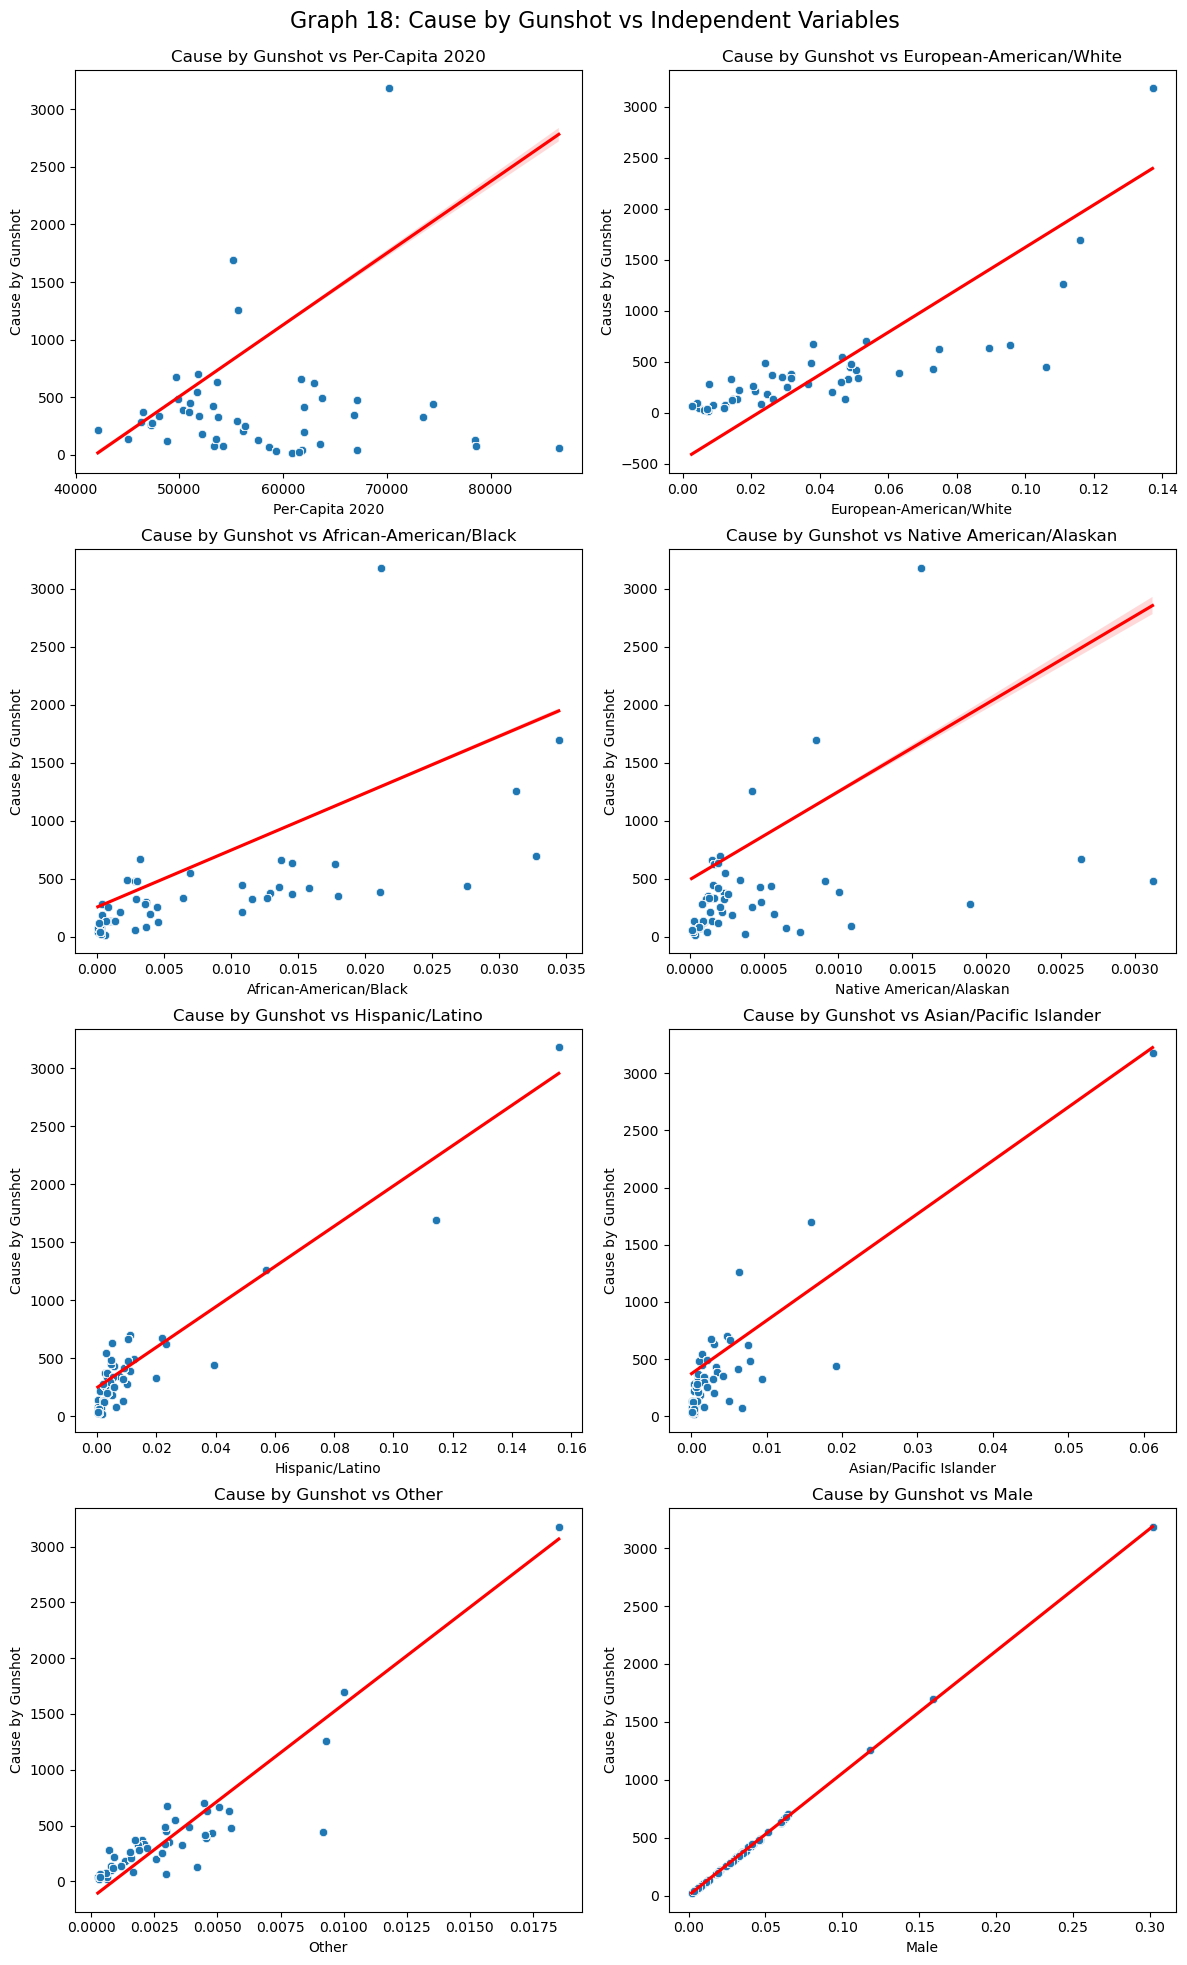

In [60]:
# Define dependent and independent variables
dep_var = 'Cause by Gunshot'
ind_vars = ['Per-Capita 2020', 'European-American/White', 'African-American/Black', 'Native American/Alaskan', 
            'Hispanic/Latino', 'Asian/Pacific Islander', 'Other', 'Male']

# Create scatterplots
n_rows = 4
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize = (12, 20))

for i, ax in enumerate(axes.flatten()):
    if i < len(ind_vars):
        sns.scatterplot(data = final_df, x = ind_vars[i], y = dep_var, ax = ax)
        sns.regplot(data = final_df, x = ind_vars[i], y = dep_var, ax = ax, scatter = False, 
                    line_kws={'color': 'red'})
        ax.set_title(f'{dep_var} vs {ind_vars[i]}')
    else:
        ax.set_visible(False)

plt.tight_layout()
fig.subplots_adjust(top=0.95)
fig.suptitle('Graph 18: Cause by Gunshot vs Independent Variables', fontsize = 16)

plt.show()

# Run regression model
final_df = sm.add_constant(final_df)
X = final_df[ind_vars + ['const']]
y = final_df[dep_var]

model5 = sm.OLS(y, X).fit()

Graph 18 illustrates the relationships between the total number of deaths caused by a gunshot in each U.S. state (the dependent variable) and various independent variables. The independent variables presented on the x-axis are: 'Per-Capita 2020' (average per-capita income in the year 2020 in each state), 'European-American/White' (European-American/White population divided by 10,000 for each state), 'African-American/Black' (African-American/Black population divided by 10,000 for each state), 'Native American/Alaskan' (Native American/Alaskan population divided by 10,000 for each state), 'Hispanic/Latino' (Hispanic/Latino population divided by 10,000 for each state), 'Asian/Pacific Islander' (Asian/Pacific Islander population divided by 10,000 for each state), 'Other' (Other race/ethnicity groups population divided by 10,000 for each state), and 'Male' (Male population divided by 10,000 for each state).

In the graph, each panel represents the relationship between the total number of gunshot-related deaths in each state and one of the independent variables. The scatterplot in each panel displays the observed data points, while the solid line represents the best-fitting linear regression line.

Visually, there appears to be a positive relationship between the total number of gunshot-related deaths and the European-American/White population, African-American/Black population, Hispanic/Latino population, Other race/ethnicity groups population, and Male population. This suggests that as these population groups increase, the total number of gunshot-related deaths in a state may also increase.

On the other hand, the relationship between the total number of gunshot-related deaths and the Native American/Alaskan population and Asian/Pacific Islander population seems to be less evident.

Regarding the 'Per-Capita 2020' variable, it is difficult to discern a strong or consistent relationship with the total number of gunshot-related deaths from the graph alone. Further statistical analysis would be required to determine the significance and strength of the associations between each independent variable and the total number of gunshot-related deaths in each state.

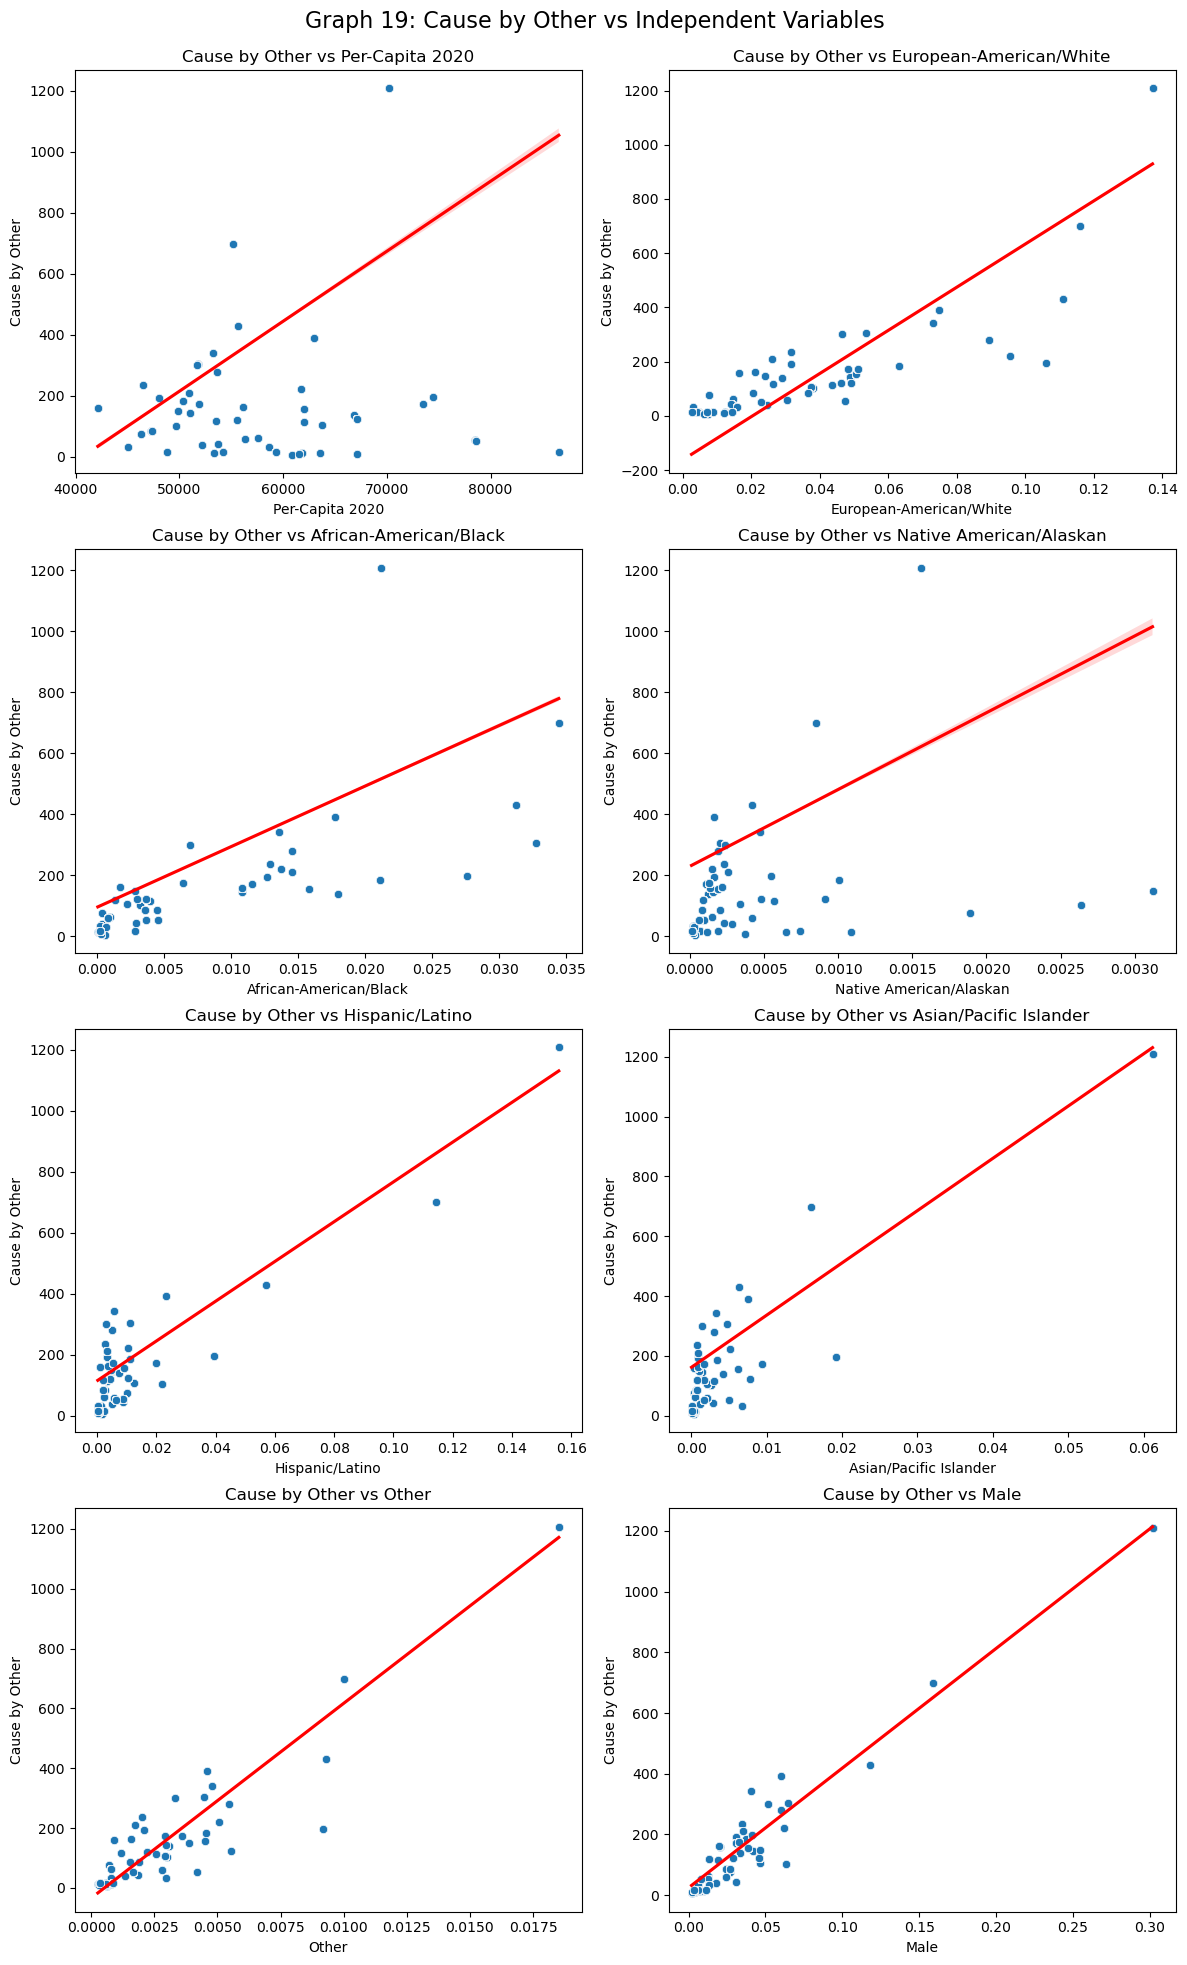

In [61]:
# Define dependent and independent variables
dep_var = 'Cause by Other'
ind_vars = ['Per-Capita 2020', 'European-American/White', 'African-American/Black', 'Native American/Alaskan', 
            'Hispanic/Latino', 'Asian/Pacific Islander', 'Other', 'Male']

# Create scatterplots
n_rows = 4
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize = (12, 20))

for i, ax in enumerate(axes.flatten()):
    if i < len(ind_vars):
        sns.scatterplot(data = final_df, x = ind_vars[i], y = dep_var, ax = ax)
        sns.regplot(data = final_df, x = ind_vars[i], y = dep_var, ax = ax, scatter = False, 
                    line_kws={'color': 'red'})
        ax.set_title(f'{dep_var} vs {ind_vars[i]}')
    else:
        ax.set_visible(False)

plt.tight_layout()
fig.subplots_adjust(top=0.95)
fig.suptitle('Graph 19: Cause by Other vs Independent Variables', fontsize = 16)

plt.show()

# Run regression model
final_df = sm.add_constant(final_df)
X = final_df[ind_vars + ['const']]
y = final_df[dep_var]

model6 = sm.OLS(y, X).fit()

Graph 19 illustrates the relationships between the number of deaths caused by factors other than gunshots in each U.S. state (the dependent variable) and various independent variables. Similar to Graph 18, the independent variables presented on the x-axis are: 'Per-Capita 2020', 'European-American/White,' 'African-American/Black,' 'Native American/Alaskan,' 'Hispanic/Latino,' 'Asian/Pacific Islander,' 'Other,' and 'Male.'

In the graph, each panel represents the relationship between the total number of non-gunshot-related deaths in each state and one of the independent variables. The scatterplot in each panel displays the observed data points, while the solid line represents the best-fitting linear regression line.

Visually, there appears to be a positive relationship between the total number of non-gunshot-related deaths and the European-American/White population, African-American/Black population, Hispanic/Latino population, Other race/ethnicity groups population, and Male population. These relationships are similar to those observed in Graph 18, which focused on gunshot-related deaths.

On the other hand, the relationship between the total number of non-gunshot-related deaths and the Native American/Alaskan population and Asian/Pacific Islander population seem to be less clear, as observed in Graph 18 as well.

Regarding the 'Per-Capita 2020' variable, the relationship with the total number of non-gunshot-related deaths is still not discernible from the graph alone. This is also consistent with the findings in Graph 18.

While there are similarities between Graph 18 and Graph 19 in terms of the relationships between the dependent variables and the independent variables, further statistical analysis would be required to determine the significance and strength of the associations, as well as any potential differences in the relationships when focusing on gunshot-related versus non-gunshot-related deaths.

In [62]:
# Create stargazer table
stargazer = Stargazer([model5, model6])
stargazer.title("Table 13: Full Model with Cause by Gunshot/Other as the Response Variable")
stargazer.custom_columns(["Model 5", "Model 6"], [1, 1])

# Display the stargazer table as an HTML table
HTML(stargazer.render_html())

The table presents the results of two linear regression models that examine the relationship between various demographic factors and the number of deaths caused by gunshots (Model 5) and other causes (Model 6) in each U.S. state. The independent variables in both models include Per-Capita Income in 2020, populations of various racial/ethnic groups (European-American/White, African-American/Black, Native American/Alaskan, Hispanic/Latino, Asian/Pacific Islander, Other), and Male population. All population variables are divided by 10,000 for each state.

Model 5 has an adjusted R-squared value of 1.000, indicating that the independent variables explain virtually all the variation in the number of deaths caused by gunshots across states. Model 6 has an adjusted R-squared value of 0.983, suggesting that the independent variables explain approximately 98.3% of the variation in the number of deaths caused by other factors across states.

In both models, the coefficients for African-American/Black, Asian/Pacific Islander, European-American/White, Hispanic/Latino, Male, Native American/Alaskan, and Other are statistically significant at the 1% level. The coefficients for Per-Capita Income in 2020 are also statistically significant at the 1% level in both models.

In Model 5, the coefficients for African-American/Black, Hispanic/Latino, Male, and Other populations are positive, indicating that an increase in these population groups is associated with increased gunshot-related deaths. Conversely, the coefficients for Asian/Pacific Islander, European-American/White, and Native American/Alaskan populations are negative, suggesting that an increase in these population groups is associated with decreased gunshot-related deaths. 

In Model 6, all population groups, except Native American/Alaskan and Other, have positive coefficients, indicating that an increase in these population groups is associated with increased deaths caused by other factors. The coefficients for Native American/Alaskan and Other populations are negative, suggesting that an increase in these population groups is associated with decreased deaths caused by other factors.

The coefficient for Per-Capita Income in 2020 is negative and statistically significant in both models, indicating that higher per-capita income is associated with fewer deaths caused by gunshots (Model 5) and other factors (Model 6).

## Regression Evaluation and Interpretation

In [63]:
# Prepare the data
y = final_df['Cause of Death']
X = patsy.dmatrix('C(Gender) + C(Race, Treatment("European-American/White"))', final_df)

# Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Fit the logistic regression model on the training data
log_reg = LogisticRegression(solver = 'lbfgs', max_iter = 1000)
log_reg.fit(X_train, y_train)

# Make predictions on the test data
y_pred = log_reg.predict(X_test)

# Compute the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

In [64]:
# Create a DataFrame with the confusion matrix
conf_mat_df = pd.DataFrame(conf_mat, 
                           index = ["Actual 0", "Actual 1"], 
                           columns = ["Predicted 0", "Predicted 1"])

# Display the table
print("Table 14: Confusion Matrix")
display(HTML(conf_mat_df.to_html(classes='table table-bordered', header=True, index=True)))

Table 14: Confusion Matrix


In this study, we sought to investigate the relationship between the cause of death during fatal encounters and the factors of gender and race. The dependent variable, Cause of Death, is a binary variable where 1 represents death by gunshot and 0 indicates death by other means. Our independent variables are Gender and Race, with Gender consisting of three levels: Female (base level), Male, and Transgender; and Race comprising seven levels: European-American/White (base level), African-American/Black, Hispanic/Latino, Asian/Pacific Islander, Race unspecified, Middle Eastern, and Native American/Alaskan.

In the confusion matrix, the rows represent the actual class labels, and the columns represent the predicted class labels. The matrix can be interpreted as follows:

1. True Negative (TN): There are 452 instances where the model correctly predicted that the actual cause of death was not due to gunshots (i.e., it was due to other means).

2. False Positive (FP): There are 1,884 instances where the model falsely predicted the cause of death to be due to gunshots, while in reality, the cause was other means.

3. False Negative (FN): There are 312 instances where the model falsely predicted that the actual cause of death was not due to gunshots, while in reality, the cause was due to gunshots.

4. True Positive (TP): There are 5,560 instances where the model correctly predicted that the actual cause of death was due to gunshots.

Based on this confusion matrix, we can calculate various performance metrics for the logistic regression model:

1. Accuracy: $\frac{TN + TP}{TN + FP + FN + TP} = \frac{452 + 5560}{452 + 1884 + 312 + 5560} = 0.729$

2. Sensitivity/Recall: $\frac{TP}{TP + FN} = \frac{5560}{5560 + 312} = 0.947$

3. Specificity: $\frac{TN}{TN + FP} = \frac{452}{452 + 1884} = 0.193$

4. Precision: $\frac{TP}{TP + FP} = \frac{5560}{5560 + 1884} = 0.747$

The table demonstrates the model's performance in predicting the cause of death in fatal encounters based on the factors of gender and race. The model has a relatively high sensitivity (0.947), indicating that it correctly identifies a large proportion of actual gunshot-related deaths. However, the specificity is relatively low (0.193), suggesting the model has difficulty correctly identifying deaths caused by other means. The model's overall accuracy is 0.729, and the precision is 0.747.

In [65]:
def model_evaluation(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, rmse, mae

# Generate predictions for Model 5 and Model 6
y5_pred = model5.predict(X)
y6_pred = model6.predict(X)

# Model 5
mse5, rmse5, mae5 = model_evaluation(y, y5_pred)

# Model 6
mse6, rmse6, mae6 = model_evaluation(y, y6_pred)

In [66]:
# Create a dictionary with evaluation metrics
data = {
    "Model": ["Model 5", "Model 6"],
    "MSE": [mse5, mse6],
    "RMSE": [rmse5, rmse6],
    "MAE": [mae5, mae6]
}

# Create a DataFrame
eval_df = pd.DataFrame(data)

# Set index to the 'Model' column
eval_df.set_index("Model", inplace = True)

# Display the table
print("Table 15: Model Performance Evaluation")
display(HTML(eval_df.to_html()))

Table 15: Model Performance Evaluation


The table presents three performance metrics for Models 5 and 6, designed to assess the relationship between the total number of deaths caused by gunshots (Model 5) or other factors (Model 6) in police fatal encounters across U.S. states and various independent variables. These independent variables include average per-capita income in 2020, race/ethnicity group populations divided by 10,000 for each state, and male population divided by 10,000 for each state.

The performance metrics displayed in the table are Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Error (MAE):

For Model 5, the Mean Squared Error for Model 5 is 2.063345e+06, the average squared difference between the predicted and actual values for the number of deaths caused by gunshots. The Root Mean Squared Error for Model 5 is 1436.434796, the square root of MSE, providing a measure of the prediction error in the same unit as the dependent variable. The Mean Absolute Error for Model 5 is 777.677981, the average absolute difference between the predicted and actual values for the number of deaths caused by gunshots.

For Model 6, the Mean Squared Error for Model 6 is 1.756230e+08, the average squared difference between the predicted and actual values for the number of deaths caused by other factors. The Root Mean Squared Error for Model 6 is 13252.283386. The Mean Absolute Error for Model 6 is 8982.602359, the average absolute difference between the predicted and actual values for the number of deaths caused by other factors.

Comparing Models 5 and 6, we can observe that Model 5 has lower values for all three performance metrics (MSE, RMSE, and MAE) than Model 6. This suggests that Model 5, which predicts the number of deaths caused by gunshots, has better predictive accuracy than Model 6, which predicts the number of deaths caused by other factors. The lower values in Model 5 indicate that the model has fewer prediction errors on average compared to Model 6.

## Regression Tree

Regularization parameters are added to the objective functions like multiplications to the sum of squared differences of the coefficients. They serve as a penalty term to the coefficients to reduce the model complexity. A higher regularization parameter adds more penalty to the coefficients and shrinks them to be closer to zero. However, a higher penalty can also lead to the under-fitting of the model. I used regression trees, which do not apply to regularization parameters. Instead, I could let the built-in functions decide, or I manually decide the best depth for my trees. 

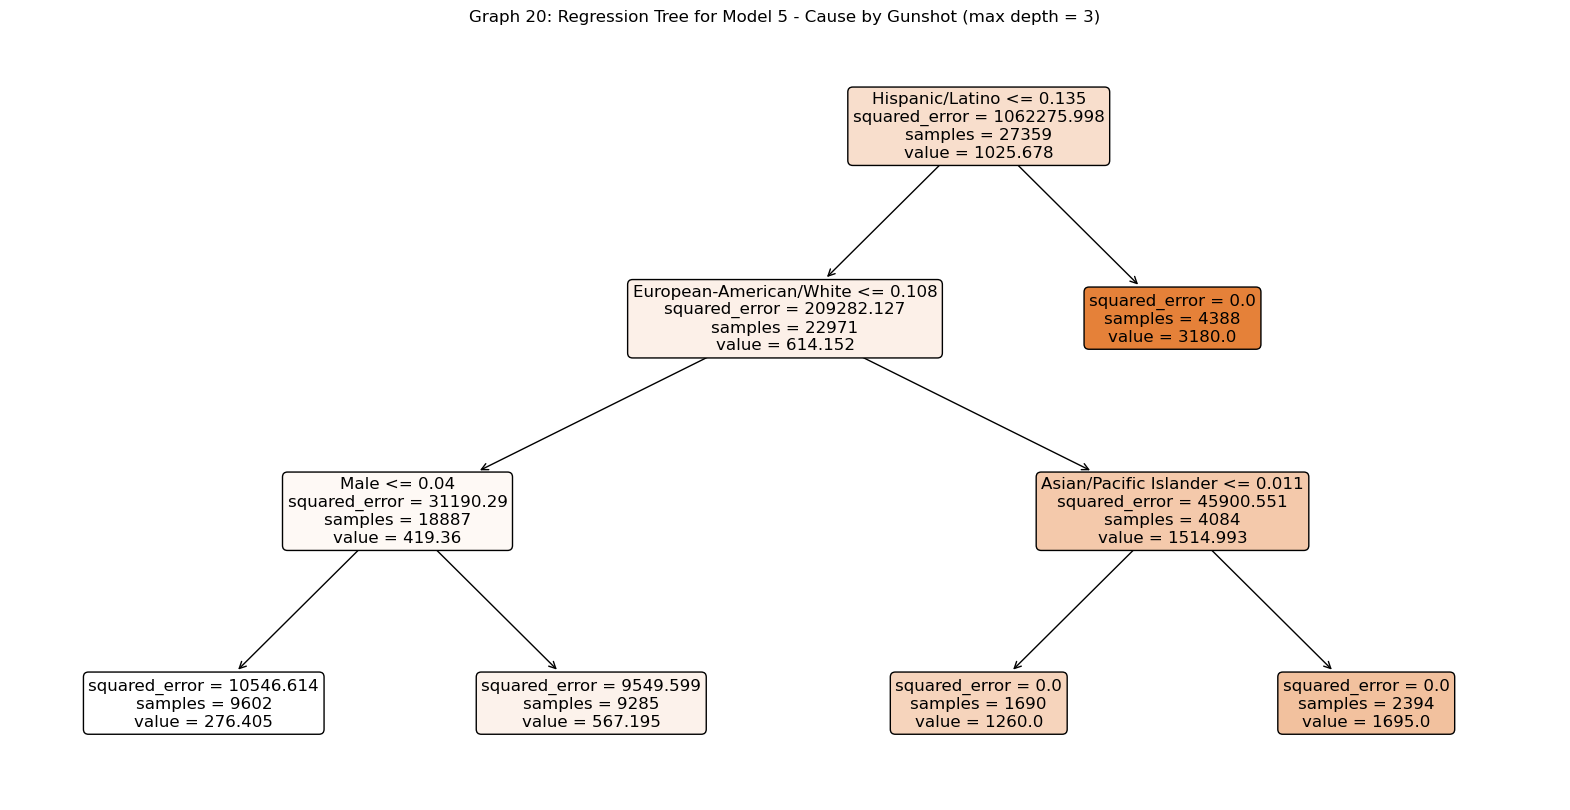

In [67]:
def best_tree_depth(X, y, random_state = 42):
    param_grid = {'max_depth': range(1, 4)}  # Set a range of depths to test

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(DecisionTreeRegressor(random_state = random_state), param_grid, cv = 5, 
                               scoring = 'neg_mean_squared_error')
    grid_search.fit(X, y)

    # Get the best max_depth
    best_depth = grid_search.best_params_['max_depth']
    return best_depth

# Model 5: Cause by Gunshot
dep_var = 'Cause by Gunshot'
ind_vars_model5 = ['Per-Capita 2020', 'European-American/White', 'African-American/Black', 'Native American/Alaskan', 
            'Hispanic/Latino', 'Asian/Pacific Islander', 'Other', 'Male']

X_model5 = final_df[ind_vars_model5]
y_model5 = final_df[dep_var]

# Find the best depth for Model 5
best_depth_model5 = best_tree_depth(X_model5, y_model5)

# Train and plot the tree with the best depth for Model 5
tree_model5 = DecisionTreeRegressor(max_depth = best_depth_model5, random_state = 42)
tree_model5.fit(X_model5, y_model5)

plt.figure(figsize = (20, 10))
plot_tree(tree_model5, feature_names = ind_vars_model5, filled = True, rounded = True, fontsize = 12)
plt.title(f"Graph 20: Regression Tree for Model 5 - Cause by Gunshot (max depth = {best_depth_model5})")
plt.show()

The regression tree plot for Model 5 displays the model's decision process in predicting the number of deaths caused by gunshots in each U.S. state based on various demographic factors. The independent variables include Per-Capita Income in 2020 and European-American/White, African-American/Black, Native American/Alaskan, Hispanic/Latino, Asian/Pacific Islander, Other racial/ethnic groups, and Male population. All population variables are divided by 10,000 for each state.

The objective function, or in other words, the Mean Squared Error (MSE), is calculated as: 
$$MSE = \frac{\sum{(y - \hat{y}})^2}{n}$$
Where $y$ represents the observed value of the dependent variable, the total number of gunshot deaths, $\hat{y}$ represents the predicted value of the dependent variable (mean value within the node), and $n$ represents the number of samples in the node. So the objective function here is the mean of the squared difference between the observed number of gunshot deaths and the predicted number of gunshot deaths. The lower the MSE, the better the prediction result.

The tree begins with a root node, which splits the dataset based on the Hispanic/Latino population. The squared error (SE) at the root node is 1,062,275.998, which means the error of prediction is high here. The node contains 27,359 samples with an average value (V) of 1,025.678 deaths caused by gunshots. The tree then branches into two nodes:

1. Left Node: European-American/White population less than or equal to 0.108 (1,080 individuals per 10,000). The SE at this node is 209,282.127, which means the error of prediction is high here. However, the error of prediction decreases a bit compared to the root node. The node contains 22,971 samples with an average value of 614.152 deaths caused by gunshots. This node further splits into two child nodes: 

    a. Left Child Node: Male population less than or equal to 0.04 (400 males per 10,000). The SE is 31,190.29, which means the error of prediction is high here. However, we can see the trend here that the error of prediction gradually decreases as the tree branches down. The node contains 18,887 samples with an average value of 419.36 deaths caused by gunshots.

        i. Left Leaf Node: The SE is 10,546.614, which means the error of prediction is high here. The node contains 9,602 samples with an average value of 276.405 deaths caused by gunshots.

        ii. Right Leaf Node: The SE is 9,549.599, which means the error of prediction is high here. The node contains 9,285 samples with an average value of 567.195 deaths caused by gunshots.

    b. Right Child Node: Asian/Pacific Islander population less than or equal to 0.011 (110 individuals per 10,000). The SE is 45,900.551, which means the error of prediction is high here. The node contains 4,084 samples with an average value of 1,514.993 deaths caused by gunshots.

        i. Left Leaf Node: The SE is 0.0, which means the error of prediction is zero here. The node contains 1,690 samples with an average value of 1,260 deaths caused by gunshots.

        ii. Right Leaf Node: The SE is 0.0, which means the error of prediction is also zero here. The node contains 2,394 samples with an average value of 1,695 deaths caused by gunshots.

2. Right Node: Hispanic/Latino population greater than 0.135 (1,350 individuals per 10,000). The SE at this node is 0.0, which means the error of prediction is zero here. The node contains 4,388 samples with an average value of 3,180 deaths caused by gunshots. This node is a leaf node with no further splits.

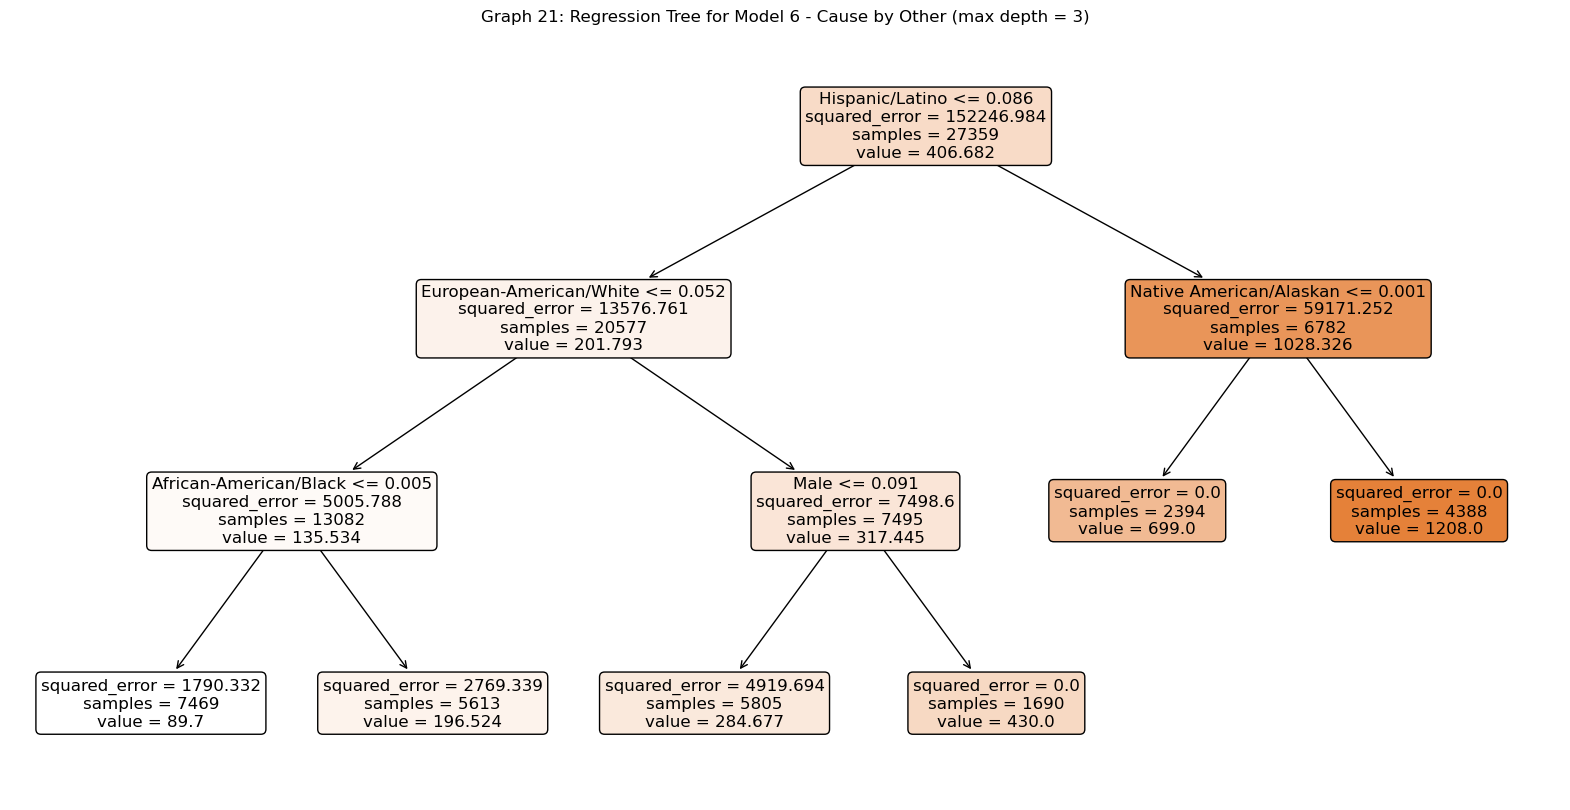

In [68]:
# Model 6: Cause by Other
dep_var = 'Cause by Other'
ind_vars_model6 = ['Per-Capita 2020', 'European-American/White', 'African-American/Black', 'Native American/Alaskan', 
            'Hispanic/Latino', 'Asian/Pacific Islander', 'Other', 'Male']

X_model6 = final_df[ind_vars_model6]
y_model6 = final_df[dep_var]

# Find the best depth for Model 6
best_depth_model6 = best_tree_depth(X_model6, y_model6)

# Train and plot the tree with the best depth for Model 6
tree_model6 = DecisionTreeRegressor(max_depth = best_depth_model6, random_state = 42)
tree_model6.fit(X_model6, y_model6)

plt.figure(figsize = (20, 10))
plot_tree(tree_model6, feature_names = ind_vars_model6, filled = True, rounded = True, fontsize = 12)
plt.title(f"Graph 21: Regression Tree for Model 6 - Cause by Other (max depth = {best_depth_model6})")
plt.show()

The regression tree plot for Model 6 displays the model's decision process in predicting the number of deaths caused by other factors in each U.S. state. The independent variables are the same as Model 5's.

The objective function here will be the same in the format as the previous MSE function. However, for Model 6, $y$ represents the observed value of the total number of deaths caused by factors other than gunshots, and $\hat{y}$ represents the predicted value of the dependent variable. $n$ represents the number of samples in the node for other deaths. So the objective function here is the mean of the squared difference between the observed number of deaths by other means and the predicted number of deaths by other means.

The tree begins with a root node, which splits the dataset based on the Hispanic/Latino population. The squared error (SE) at the root node is 152,246.984, which means the error of prediction is high here. The node contains 27,359 samples with an average value (V) of 406.682 deaths caused by factors other than gunshots. The tree then branches into two nodes:

1. Left Node: European-American/White population less than or equal to 0.052 (520 individuals per 10,000). The SE at this node is 13,576.761, which means the error of prediction is high here. However, compared to the root node, the error of prediction decreases a lot. The node contains 20,577 samples with an average value of 201.793 deaths caused by factors other than gunshots. This node further splits into two child nodes:

    a. Left Child Node: African-American/Black population less than or equal to 0.005 (50 individuals per 10,000). The SE is 5,005.788, which means the error of prediction is still relatively high here. However, we can see the trend here that as the tree branches down, the error of prediction shrinks with it. The node contains 13,082 samples with an average value of 135.534 deaths caused by factors other than gunshots.

        i. Left Leaf Node: The SE is 1,790.332, which means the error of prediction is relatively high here. The node contains 7,469 samples with an average value of 89.7 deaths caused by factors other than gunshots.

        ii. Right Leaf Node: The SE is 2,769.339, which means the error of prediction is high here. The node contains 5,613 samples with an average value of 196.524 deaths caused by factors other than gunshots.

    b. Right Child Node: Male population less than or equal to 0.091 (910 males per 10,000). The SE is 7,498.6, which means the error of prediction is high here. The node contains 7,495 samples with an average value of 317.445 deaths caused by factors other than gunshots.

        i. Left Leaf Node: The SE is 4,919.694, which means the error of prediction is high here. The node contains 5805 samples with an average value of 284.677 deaths caused by factors other than gunshots.
        
        2. Right Leaf Node: The SE is 0.0, which means the error of prediction is zero here. The node contains 1690 samples with an average value of 430.0 deaths caused by factors other than gunshots.

2. Right Node: Native American/Alaskan population less than or equal to 0.001 (10 individuals per 10,000). The SE at this node is 59,171.252, which means the error of prediction is high here. The node contains 6,782 samples with an average value of 1,028.326 deaths caused by factors other than gunshots. This node further splits into two child nodes:

    a. Left Leaf Node: The SE is 0.0, which means the error of prediction is zero here. The node contains 2394 samples with an average value of 699.0 deaths caused by factors other than gunshots.

    b. Right Leaf Node: The SE is 0.0, which means the error of prediction is zero here. The node contains 4388 samples with an average value of 1208.0 deaths caused by factors other than gunshots.

Both trees start with the Hispanic/Latino population as the root node for the decision process, suggesting that this variable plays a significant role in determining the number of deaths in both categories. However, the subsequent splits in the trees differ, indicating that the demographic factors influencing the number of deaths caused by gunshots and other factors are different. In Model 5, the European-American/White and Male populations are the next most significant factors. In contrast, in Model 6, the European-American/White population and Native American/Alaskan population are more influential. The squared errors and the number of samples at each node and leaf also differ between the two models.

In [69]:
final_df = pd.merge(df_with_income, census_df, on = 'State', how = "outer").dropna()
final_df['Population'] = final_df['Population'].astype(float)
final_df['Per_Capita_2020'] = final_df['Per_Capita_2020'].astype(float)
final_df['Euro_American_White'] = final_df['Euro_American_White'].astype(float)
final_df['Afri_American_Black'] = final_df['Afri_American_Black'].astype(float)
final_df['Native_Alaskan'] = final_df['Native_Alaskan'].astype(float)
final_df['Hispanic_Latino'] = final_df['Hispanic_Latino'].astype(float)
final_df['Asian_Pacific_Islander'] = final_df['Asian_Pacific_Islander'].astype(float)
final_df['Other'] = final_df['Other'].astype(float)
final_df = final_df.rename(columns = {"Cause_of_death": "Cause of Death"})

In [70]:
# One-hot encoding the categorical features
encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(final_df[['Gender', 'Race']]).toarray()
y = final_df['Cause of Death']

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.3, random_state = 42)

# Train a random forest with one tree
rf = RandomForestClassifier(n_estimators = 1, max_depth = 3, random_state = 42)
rf.fit(X_train, y_train)

# Get the feature names and convert to a list
feature_names = encoder.get_feature_names_out(['Gender', 'Race']).tolist()
tree_text = export_text(rf.estimators_[0], feature_names = feature_names)
# print(tree_text)

In [71]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.3, random_state = 42)

# Range of depths to test
depths = range(1, 21)

# Store test set accuracy scores for each depth
test_accuracies = []

# Train and evaluate a model for each depth
for depth in depths:
    rf = RandomForestClassifier(n_estimators = 1, max_depth = depth, random_state = 42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    test_accuracies.append(accuracy)
#    print(f"Depth: {depth}, Test set accuracy: {accuracy:.4f}")

# Find the best depth
best_depth = depths[np.argmax(test_accuracies)]

# Train the model with the best depth
best_rf = RandomForestClassifier(n_estimators = 1, max_depth = best_depth, random_state = 42)
best_rf.fit(X_train, y_train)
tree_text = export_text(best_rf.estimators_[0], feature_names = feature_names)
# print(tree_text)

In [72]:
fig = px.line(x = depths, y = test_accuracies, 
              labels = {'x': 'Depth', 'y': 'Test set accuracy'}, 
              title = 'Graph 22: Test set accuracy vs Depth')
fig.show()

Graph 23 represents the performance of our logistic model with the binary Cause of Death as the dependent variable. The graph's horizontal axis displays the maximum depth of the decision tree, ranging from 1 to 20, while the vertical axis represents the model's performance measured by test accuracy. The test accuracy initially decreases as the tree depth increases but starts increasing after reaching a certain depth (around depth 4). This increase suggests that the model is overfitting the training data when the tree depth is over depth 4, leading to poorer performance on the test dataset. 

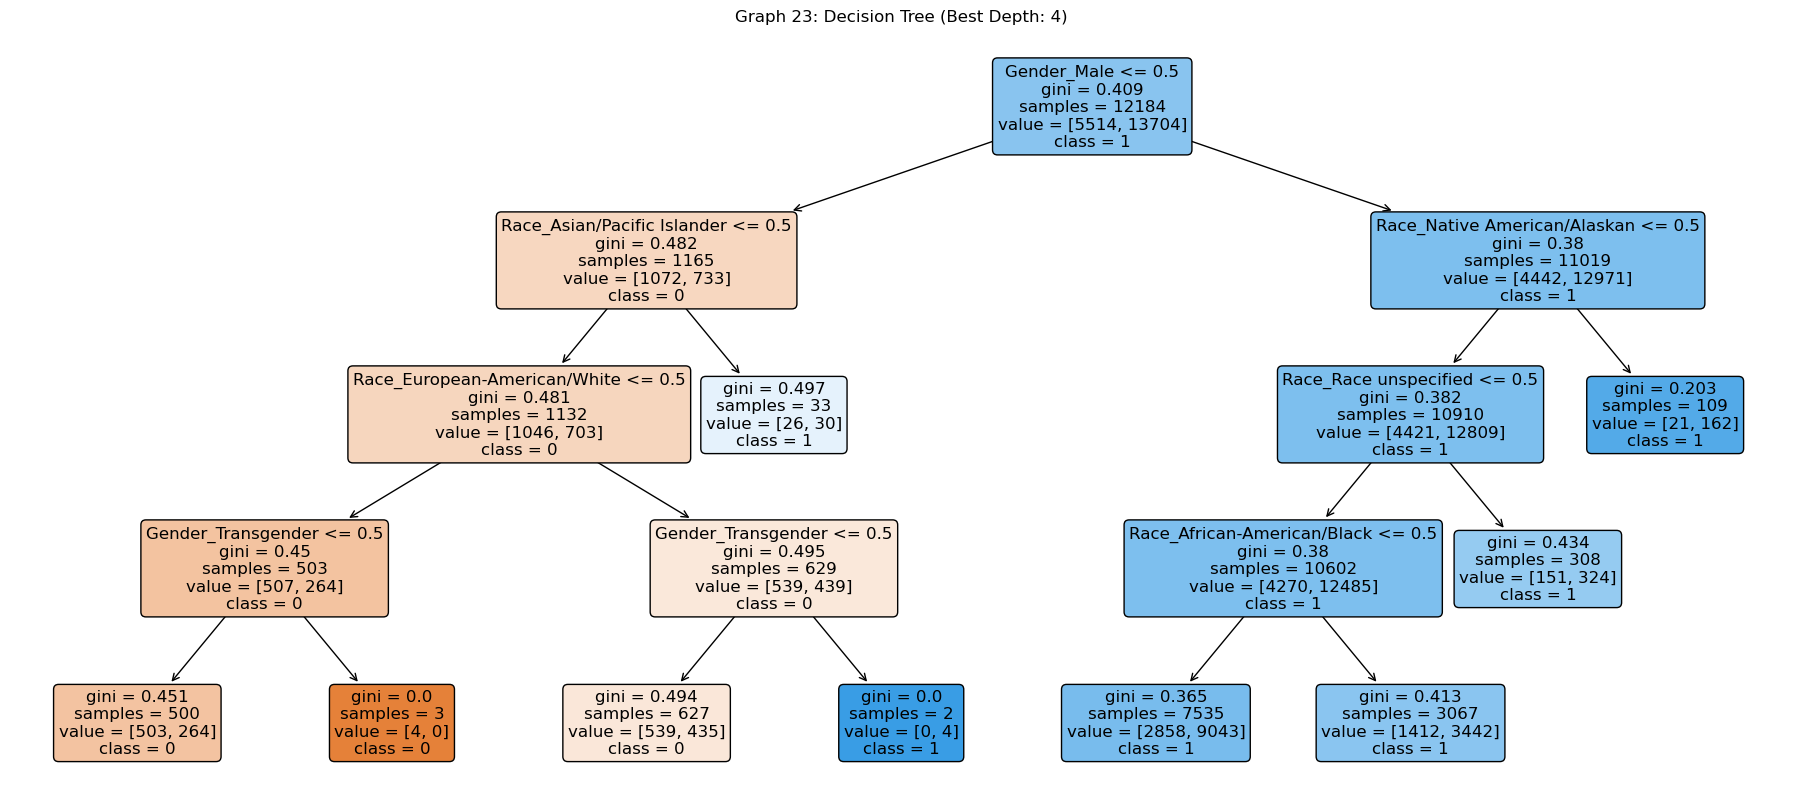

In [73]:
# Train the model with the best depth
best_rf = RandomForestClassifier(n_estimators = 1, max_depth = best_depth, random_state = 42)
best_rf.fit(X_train, y_train)

# Plot the decision tree with the best depth (4)
plt.figure(figsize = (23,10))
plot_tree(best_rf.estimators_[0], feature_names = feature_names, class_names = ['0', '1'], 
          filled = True, rounded = True, fontsize = 12)
plt.title(f"Graph 23: Decision Tree (Best Depth: {best_depth})")
plt.show()

Graph 23 is derived from the logistic regression model with a binary variable indicating whether one victim died from a gunshot death (1) or another death (0) as the dependent variable and two factor variables, Gender, and Race, as the independent variables. The objective function for this model is based on minimizing the Gini impurity. The Gini impurity is calculated as below:
$$1 - \sum{(p_i)^2}$$
Where $p_i$ is the probability of class $i$ in a node, in this case, $p_i$ will be the probability of dying from a gunshot or another way other than a gunshot. A lower Gini impurity can be interpreted as a smaller error of prediction.

The first split in the decision tree is based on the Gender Male. If the individual is either Female or Transgender, the tree branches to the left. If the individual is Male, the tree branches to the right. The Gini impurity of 0.409 suggests a moderate impurity level in the samples. A sample of 12184 is the sample size before any split has happened. This node indicates that 5514 observations are in class 0 (other deaths), and 13704 are in class 1 (gunshot deaths). The majority class in the root node is class 1 (gunshot deaths). 

1. Left node: If the individual is not an Asian/Pacific Islander, the tree continues branching to the left. Otherwise, it branches to the right. The Gini impurity of 0.482 suggests a moderate impurity level in the samples. A sample of 1165 is divided into this node. This node indicates that 1072 observations are in class 0, and 733 observations are in class 1. The majority class in this node is class 0.

    a. Left child node: If the individual is not a European-American/White, the tree continues branching to the left. Otherwise, it branches to the right. The Gini impurity of 0.481 suggests a moderate impurity level in the samples. A sample of 1132 is divided into this node. This node indicates that 1046 observations are in class 0, and 703 are in class 1. The majority class in this node is class 0.
    
        i. Left child node: If the individual is either Female or Male, the tree continues branching to the left. Otherwise, it branches to the right. The Gini impurity of 0.45 suggests a moderate impurity level in the samples. A sample of 503 is divided into this node. This node indicates that 507 observations are in class 0, and 264 are in class 1. The majority class in this node is class 0.
        
            - Left leaf node: When the individual is either Female or Male, the Gini impurity of 0.451 suggests a moderate impurity level in the samples. A sample of 500 is divided into this node. This node indicates that 503 observations are in class 0, and 264 are in class 1. The majority class in this node is class 0.
            
            - Right leaf node: When the individual is Transgender, the Gini impurity of 0 suggests a pure sample. A sample of 3 is divided into this node, and this node indicates that all 4 observations are in class 0. 
        
        ii. Right child node: If the individual is either Female or Male, the tree continues branching to the left. Otherwise, it branches to the right. The Gini impurity of 0.495 suggests a moderate impurity level in the samples. A sample of 629 is divided into this node. This node indicates that 539 observations are in class 0 and 439 in class 1. The majority class in this node is class 0.
        
            - Left leaf node: When the individual is either Female or Male, the Gini impurity of 0.494 suggests a moderate impurity level in the samples. A sample of 627 is divided into this node. This node indicates that 539 observations are in class 0, and 435 are in class 1. The majority class in this node is class 0.
            
            - Right leaf node: When the individual is Transgender, the Gini impurity of 0 suggests a pure sample. A sample of 2 is divided into this node, and this node indicates that all 4 observations are in class 1. 
    
    b. Right leaf node: When the individual is an Asian/Pacific Islander, the Gini impurity of 0.497 suggests a moderate impurity level in the samples. A sample of 33 is divided into this node. This node indicates that 26 observations are in class 0, and 30 are in class 1. The majority class in this node is class 1.

2. Right node: If the individual is not a Native American/Alaskan, the tree continues branching to the left. Otherwise, it branches to the right. The Gini impurity of 0.38 suggests a slightly better impurity level in the samples than in the left node. A sample of 11019 is divided into this node. This node indicates that 4442 observations are in class 0, and 12971 observations are in class 1. The majority class in this node is class 1.

    a. Left child node: If the individual is race specified, the tree continues branching to the left. Otherwise, it branches to the right. The Gini impurity of 0.382 suggests a medium impurity level in the samples. A sample of 10910 is divided into this node. This node indicates that 4421 observations are in class 0, and 12809 observations are in class 1. The majority class in this node is class 1.
    
        i. Left child node: If the individual is not African-American/Black, the tree continues branching to the left. Otherwise, it branches to the right. The Gini impurity of 0.38 suggests a medium impurity level in the samples. A sample of 10602 is divided into this node. This node indicates that 4270 observations are in class 0, and 12485 observations are in class 1. The majority class in this node is class 1.
        
            - Left leaf node: When the individual is not African-American/Black, the Gini impurity of 0.365 suggests a medium impurity level in the samples. A sample of 7535 is divided into this node. This node indicates that 2858 observations are in class 0, and 9043 are in class 1. The majority class in this node is class 1.
            
            - Right leaf node: When the individual is African-American Black, the Gini impurity of 0.413 suggests a moderate impurity level in the samples. A sample of 3067 is divided into this node. This node indicates that 1412 observations are in class 0, and 3442 observations are in class 1. The majority class in this node is class 1.
        
        ii. Right leaf node: When the individual is race unspecified, the Gini impurity of 0.434 suggests a slightly worse impurity level in the samples than in the left node. A sample of 308 is divided into this node. This node indicates that 151 observations are in class 0, and 324 are in class 1. The majority class in this node is class 1.
    
    b. Right leaf node: When the individual is a Native American/Alaskan, the Gini impurity of 0.203 suggests a slightly better impurity level in the samples than the left node. A sample of 109 is divided into this node. This node indicates that 21 observations are in class 0, and 162 are in class 1. The majority class in this node is class 1.

## Comparing between the OLS and the Regression Tree Results

In the first logistic regression model, we observe that gender (Male), race (African-American/Black), and race (unspecified) are the three most statistically significant factors among all factors. Among these, males are more likely than females to encounter fatal shootings when police are present. Compared to the European-American/White racial group, African-American/Black and unspecified racial groups are less likely to experience fatal shootings. Furthermore, gender (Transgender) and race (Native American/Alaskan) are statistically significant factors. Transgender individuals are more likely than females to encounter fatal shootings when police are present, and Native American/Alaskan individuals are more likely to experience fatal shootings than European-American/White racial groups.

For the first model, both the regression model and the regression tree identify the Male gender as the most critical determining factor, with males being more susceptible to gunshots. The regression model does not explicitly indicate whether Asian/Pacific Islander or Native American/Alaskan are the next most important variables. In the regression model, the increased likelihood for Asian/Pacific Islander and Native American/Alaskan is compared to the base level of European-American/White. In contrast, the regression tree directly classifies the Asian/Pacific Islander group into a class that is relatively less likely to experience gunshots. The Native American/Alaskan group is classified into a class that is relatively more likely to be shot.

In the second linear regression model, with the number of fatal shootings encountered in each state in the United States under police presence as the dependent variable, the number of males in each state is the most influential independent variable regarding economic significance. This is followed by the number of Native American/Alaskan and Other race groups, and finally, the number of African-American/Black and Asian/Pacific Islander individuals. The numbers of European-American/White and Hispanic/Latino individuals are relatively less significant in magnitude. However, the degree of significance of these gender and race-related data is not significantly different when measured by statistical significance. Among these, African-American/Black, Hispanic/Latino, Male, and Other race group numbers positively correlate with the number of fatal shooting victims.

In the third linear regression model, with the number of non-shooting-related fatalities encountered in each state in the United States under police presence as the dependent variable, the numbers of Native American/Alaskan and Other race groups are the most influential in terms of economic significance. This is followed by Asian/Pacific Islander, European-American/White, African-American/Black, and Male individuals. Hispanic/Latino individuals have a relatively larger impact in this model compared to the previous one. However, their influence is less evident than the other variables in this model. However, statistically speaking, the degree of statistical significance of these independent variables is roughly similar. Among these, African-American/Black, Asian/Pacific Islander, European-American/White, Hispanic/Latino, and Male individuals correlate positively with the number of non-shooting-related fatalities.

Since the focus of the regression tree is not on measuring the relationship between independent and dependent variables but rather on partitioning the data based on values like MSE, it is difficult to determine whether the root node Hispanic/Latino population chosen in the second and third models can yield the smallest MSE in the regression analysis. The most important independent variables identified by the regression model and regression tree also differ.

In comparison, the regression model is better suited for determining the relationship between independent and dependent variables under controlled conditions, which can be used for causal inference between Race/Gender and Cause of Death or between Race/Gender population and Gunshot/Other Death Population. All levels must be included for categorical indicators in the model, with comparisons made between the base level and other levels. On the other hand, the regression tree is more suitable for making predictions, and its algorithm can be used to select more precise or broadly applicable general predictions. It does not focus on studying the relationship between independent and dependent variables or the relationships within each indicator. One advantage of the regression model is that, in the absence of randomization, including more covariates may make the model more complex but can also improve the accuracy of its results. However, this is not an advantage for the regression tree. The more content a regression tree includes the more likely it is to be confined to the training dataset and difficult to apply to the general population.

## Conclusion and Future Work

Our analysis of the binary variable concerning whether a death in police presence is attributable to a gunshot, alongside the state where the incident occurred, the gender, and the victims' race, reveals substantial variations across categories. This suggests an association between each pair of indicators and the response variable. While certain states report higher death counts, adjusting for state population significantly alters the proportion of gunshot-related fatalities. Although gunshots account for most deaths, females are less likely to be killed by gunfire, and males exhibit a higher death rate than other genders. Furthermore, despite the notable scale of European-American/White fatalities during fatal encounters, adjusting for population sizes across racial and ethnic groups reveals that the white population is less likely to experience police violence.

Importantly, there is no discernible association between the three indicator variables—gender, race, and location of victims—suggesting that it is improbable that these indicators exert a collective influence on the response variable. This is advantageous for drawing causal inferences using statistical models.

In this research, we developed two fundamental regression models to investigate the factors contributing to gunshot-related fatalities. The first, a logistic regression model, examines the influence of gender and race on the likelihood of a victim's death caused by gunshot in police presence using a binary dependent variable. The second model, a linear regression, shifts focus from individual to state level, employing data on racial and gender distribution and per-capita income as independent variables while considering the total number of gunshot and non-gunshot fatalities as the dependent variable. Both models were briefly adapted into regression trees for elementary machine-learning predictions. Our findings reveal the presence of gender and racial disparities in such violent incidents, though regional differences were less pronounced, deviating from the patterns observed in geographic representations. This incongruity may be derived from the diverse gender and population compositions across states, influencing the displayed regional distributions. Notably, income disparities demonstrated low significance in both models.

The map reveals that most cases are dominated by Black individuals when calculating the mortality rates for different racial groups by combining the number of gunshot deaths with the total population of each racial group in each state. However, the regression model indicates that Black individuals are, in fact, less likely to die from gunshots than White individuals. This discrepancy may be due to the model's inability to consider the individual victim's death with the overall mortality rate for their racial group within the state through control variables. The significantly larger White population still influences the model in each state. In future research, we should consider incorporating mortality rates rather than the number of deaths to better account for this discrepancy and further enhance our understanding of the factors at play.

The Fatal Encounters dataset is continually evolving. We hope that, in the future, this dataset will encompass more societal sources, enabling us to examine the relationship between victims and deaths beyond incidents that have already occurred. As more defining traits of victims are incorporated into the data, this can also enhance our machine learning models, reducing the mean squared error and Gini impurity. Developing a theoretical framework to guide police training to reduce the frequency of deaths resulting from unprofessional actions will ultimately enhance the safety of both officers and citizens alike.

# Reference

1. Broer, Markus., Yifan Bai, and Frank Fonseca. “A Review of the Literature on Socioeconomic Status and Educational Achievement.” IEA Research for Education 5 (May 16, 2019): 7–17. https://doi.org/10.1007/978-3-030-11991-1_2. 

2. Burghart, Brian. “Fatal Encounters: A Step toward Creating an Impartial, Comprehensive and Searchable National Database of People Killed during Interactions with Police.” Fatal Encounters. University of Southern California, Eunice Kennedy Shriver National Institute of Child Health and Human Development, September 18, 2020. https://fatalencounters.org/.

3. Duffin, Erin. “Gender Distribution of Full-Time U.S. Law Enforcement Employees 2021.” Statista, October 11, 2022. https://www.statista.com/statistics/195324/gender-distribution-of-full-time-law-enforcement-employees-in-the-us/. 

4. Friesen, Corwyn. “IIU Concludes Investigation into Man's Death in Police Presence.” mySteinbach, January 14, 2023. https://www.mysteinbach.ca/news/12054/iiu-concludes-investigation-into-mans-death-in-police-presence/. 

5. Lang, Kevin., and Ariella Kahn-Lang Spitzer. 2020. "Race Discrimination: An Economic Perspective." Journal of Economic Perspectives, 34 (2): 68-89. DOI: 10.1257/jep.34.2.68.

6. Rahman, Imran U., Jian Deng, Junrong Liu, and Mohsin Shafi. “Socio-Economic Status, Resilience, and Vulnerability of Households under Covid-19: Case of Village-Level Data in Sichuan Province.” PLOS ONE 16, no. 4 (April 29, 2021). https://doi.org/10.1371/journal.pone.0249270. 

7. Steptoe, Andrew., and Paola Zaninotto. “Lower Socioeconomic Status and the Acceleration of Aging: An Outcome-Wide Analysis.” Proceedings of the National Academy of Sciences 117, no. 26 (2020): 14911–17. https://doi.org/10.1073/pnas.1915741117. 

8. “U.S. Census Bureau Quickfacts: United States.” U.S. Census Bureau QuickFacts: United States. Population Estimates, American Community Survey, Census of Population and Housing, Current Population Survey, Small Area Health Insurance Estimates, Small Area Income and Poverty Estimates, State and County Housing Unit Estimates, County Business Patterns, Nonemployer Statistics, Economic Census, Survey of Business Owners, Building Permits., July 1, 2021. https://www.census.gov/quickfacts/fact/table/US/PST045221. 

9. “U.S. State Population by Rank (Update for 2023!).” Infoplease. Infoplease, February 13, 2023. https://www.infoplease.com/us/states/state-population-by-rank. 

10. Wikipedia contributors. (2022, January 30). List of U.S. states and territories by income. In Wikipedia, The Free Encyclopedia. Retrieved March 22, 2023, from https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_income

11. Wikipedia contributors. (2023, March 14). List of U.S. states and territories by race/ethnicity. In Wikipedia, The Free Encyclopedia. Retrieved March 22, 2023, from https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_race/ethnicity